# Litho facies prediction using well logs

In oil & gas exploration one of the crucial risk factors is reservoir quality. High quality reservoirs are the ones with a large amount of pores and good permeability (permeability measures how easy oil or gas flows out of the formation pores during production). Different types of lithology in different depositional environments (facies) have different levels of porosity and permeability. For example, sandstones are better reservoirs than siltstones because they have more pores and higher permeability. Therefore obtaining lithofacies information is essential in reservoir evaluation. 

Accurate lithology data can be obtained from core sampling during drilling. However, this procedure requires a special tool and is extremely expensive. A common approach used by most oil companies is to have an experienced geologist interprete lithofacies using wireline log measurements, for example Gammaray log (GR), Density logs, Neutron logs, Sonic logs etc.. However, the drawback of this approach is obvious - it's time-consuming and the interpreter needs to be highly skilled. Machine Learning, to be more specific, Supervised Machine Learning naturally becomes a great tool here as it can help predicting lithofacies by learning from many existing interpretations manually done by geologists. 

In this project we will investigate how different machine learning techniques work. We will use one well as the "test dataset", and try to build a model based on the logs from all the other wells ("training dataset"), and use the derived model to predict lithofacies for the test well. 

This dataset comes from 10 wells in the Hugoton and Panoma Fields in North America. Each well contains 8 logs as shown below. Among these 8 logs, logs 1-5 are measured or derived logs, 6 and 7 are indicators derived from geological information. The last one **"Facies"** is the lithofacies interpretated by geoscientists.  
1. GR: this wireline logging tools measure gamma emission
2. ILD_log10: this is resistivity measurement
3. PE: photoelectric effect log. A supplementary measurements from density tool. Less sensitive to porosity than density log, but more sensitive to minerals.
4. DeltaPHI: Phi is a porosity index in petrophysics. Density-neutron porosity difference
5. PNHIND: Average of neutron and density log.
6. NM_M:nonmarine-marine indicator
7. RELPOS: relative position
8. Facies: interpreted litho facies based on logs 1-7.

For the Facies column, there are 9 lithofacies presented as integers in the dataset. The maping is as following:

1. SS: Nonmarine sandstone
2. CSiS: Nonmarine coarse siltstone
3. FSiS: Nonmarine fine siltstone
4. SiSH: Marine siltstone and shale
5. MS: Mudstone (limestone)
6. WS: Wackestone (limestone)
7. D: Dolomite
8. PS: Packstone-grainstone (limestone)
9. BS: Phylloid-algal bafflestone (limestone)

The neighboring facies are somewhat constrained. For example facies 2 Coarse Siltstone is usually
adjacent to facies 1 (Sandstone) or facies 3 (Fine Siltstone).

Key data source: Data source is from Kaggle: https://www.kaggle.com/datasets/imeintanis/well-log-facies-dataset

## 1. Data import and wrangling

In [1541]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1.1 Data import

In [1542]:
#Import data from the csv file

data = pd.read_csv("facies_vectors.csv")
data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [1543]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


Column 0 Facies is the target feature. 
Column 4 to 8 are the conventional well logs
Column 9 NM_M: the facies is Marine or Nonmarine
Column 10 RELPOS: relative position, 

In [1544]:
wellnames = data['Well Name'].unique()
print(wellnames)

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


In [1545]:
formations = data['Formation'].unique()
print(formations)

['A1 SH' 'A1 LM' 'B1 SH' 'B1 LM' 'B2 SH' 'B2 LM' 'B3 SH' 'B3 LM' 'B4 SH'
 'B4 LM' 'B5 SH' 'B5 LM' 'C SH' 'C LM']


### 1.2 Check if any formation is missing in any well

In [1546]:
for well in wellnames :
    missingF = set(formations) - set(data.loc[data['Well Name']==well]['Formation'])
    if len(missingF) > 0:
        print('Well ', well, ' is missing formations: ', missingF)

Well  SHANKLE  is missing formations:  {'B3 LM'}
Well  CROSS H CATTLE  is missing formations:  {'B2 LM', 'B3 LM'}
Well  Recruit F9  is missing formations:  {'B5 SH', 'B3 LM', 'B4 SH', 'B4 LM', 'B1 SH', 'B2 SH', 'C SH', 'B3 SH', 'B1 LM'}
Well  CHURCHMAN BIBLE  is missing formations:  {'B5 SH'}


In [1547]:
df = pd.DataFrame(True,index=wellnames,columns=formations)
for well in wellnames:
    flist = set(data.loc[data['Well Name']==well]['Formation'])
    for f in formations:
        if f not in flist :
            df.loc[well][f] = False
df

A1 SH  A1 LM  B1 SH  B1 LM  B2 SH  B2 LM  B3 SH  B3 LM  \
SHRIMPLIN         True   True   True   True   True   True   True   True   
ALEXANDER D       True   True   True   True   True   True   True   True   
SHANKLE           True   True   True   True   True   True   True  False   
LUKE G U          True   True   True   True   True   True   True   True   
KIMZEY A          True   True   True   True   True   True   True   True   
CROSS H CATTLE    True   True   True   True   True  False   True  False   
NOLAN             True   True   True   True   True   True   True   True   
Recruit F9        True   True  False  False  False   True  False  False   
NEWBY             True   True   True   True   True   True   True   True   
CHURCHMAN BIBLE   True   True   True   True   True   True   True   True   

                 B4 SH  B4 LM  B5 SH  B5 LM   C SH  C LM  
SHRIMPLIN         True   True   True   True   True  True  
ALEXANDER D       True   True   True   True   True  True  
SHANKLE           True   True   True   True   True  True  
LUKE G U          True   True   True   True   True  True  
KIMZEY A          True   True   True   True   True  True  
CROSS H CATTLE    True   True   True   True   True  True  
NOLAN             True   True   True   True   True  True  
Recruit F9       False  False  False   True  False  True  
NEWBY             True   True   True   True   True  True  
CHURCHMAN BIBLE   True   True  False   True   True  True

### 1.3 Check for null data

In [1548]:
data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

A quick look shows missing data occur only in PE log. Let's find out which well(s) are missing PE data

In [1549]:
#check if any log curve is missing from any well
lognames = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

for well in wellnames:
    for log in lognames:
        missinglog = data.loc[data['Well Name'] == well][log].isnull().sum()
        
        #print the wells that are missing an entire log curve
        if missinglog == data.value_counts('Well Name')[well]:
            print('Log ', log, ' is missing in well ', well)

Log  PE  is missing in well  ALEXANDER D
Log  PE  is missing in well  KIMZEY A


#### Later we will deal with the null data ####

### 1.4 Visualize data

In [1550]:
import matplotlib.colors as colors

# set up color map for facies as a dictionary
facies_cmap = {1: '#ffffcc',
               2: '#8B7500', 
               3: '#ffff00', 
               4: '#9999cc', 
               5: '#5E5E5E', 
               6: '#8B8970', 
               7: '#8B3A62', 
               8: '#CDCDB4', 
               9: '#669900'}

In [1551]:
# subset for each well
shrimplin = data.loc[data['Well Name']=='SHRIMPLIN']
alexander_d = data.loc[data['Well Name']=='ALEXANDER D']
shankle = data.loc[data['Well Name']=='SHANKLE']
luke_g_u = data.loc[data['Well Name']=='LUKE G U']
kimzey_a = data.loc[data['Well Name']=='KIMZEY A']
cross_h_cattle = data.loc[data['Well Name']=='CROSS H CATTLE']
nolan = data.loc[data['Well Name']=='NOLAN']
recruite_f9 = data.loc[data['Well Name']=='Recruit F9']
newby = data.loc[data['Well Name']=='NEWBY']
churchman_bible = data.loc[data['Well Name']=='CHURCHMAN BIBLE']

In [1552]:
loglist = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'Facies']
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,recruite_f9,newby,churchman_bible]

In [1553]:
def displayLogs(df, wellname, lognames, cmap):
    fig, axes = plt.subplots(1, len(lognames), figsize=(20,10))
    
    for i, log in enumerate(lognames):
        if log!= 'Facies':
            axes[i].plot(log, 'Depth', data=df, color=cmap[i])
            axes[i].set_xlabel(log, fontsize=20)
            axes[i].set_ylim(df.Depth.min(), df.Depth.max())
            axes[i].tick_params(labelsize=15)
            axes[i].grid()
            axes[i].invert_yaxis()
        else:
            #for key in facies_cmap.keys():
            #    axes[i].fill_betweenx(df['Depth'], 0, 1, 
            #          where=(df['Facies']==key),
            #          facecolor=facies_cmap[key])
            cmap_facies = colors.ListedColormap(colors=facies_cmap.values(), name=facies_cmap.keys())
            cluster=np.repeat(np.expand_dims(df['Facies'].values,1), 100, 1)
            im=axes[i].imshow(cluster, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=1,vmax=9)
            colorbar = plt.colorbar(im)
            colorbar.ax.yaxis.set_tick_params(labelsize=25)
            axes[i].set_xlabel(log, fontsize=20)
            axes[i].set_yticks(ticks=[], labels=None)
    
    axes[0].set_ylabel('Depth(m)', fontsize=20)
    fig.suptitle('\n Well name: '+ wellname, fontsize=30)
    plt.tight_layout()
    
    

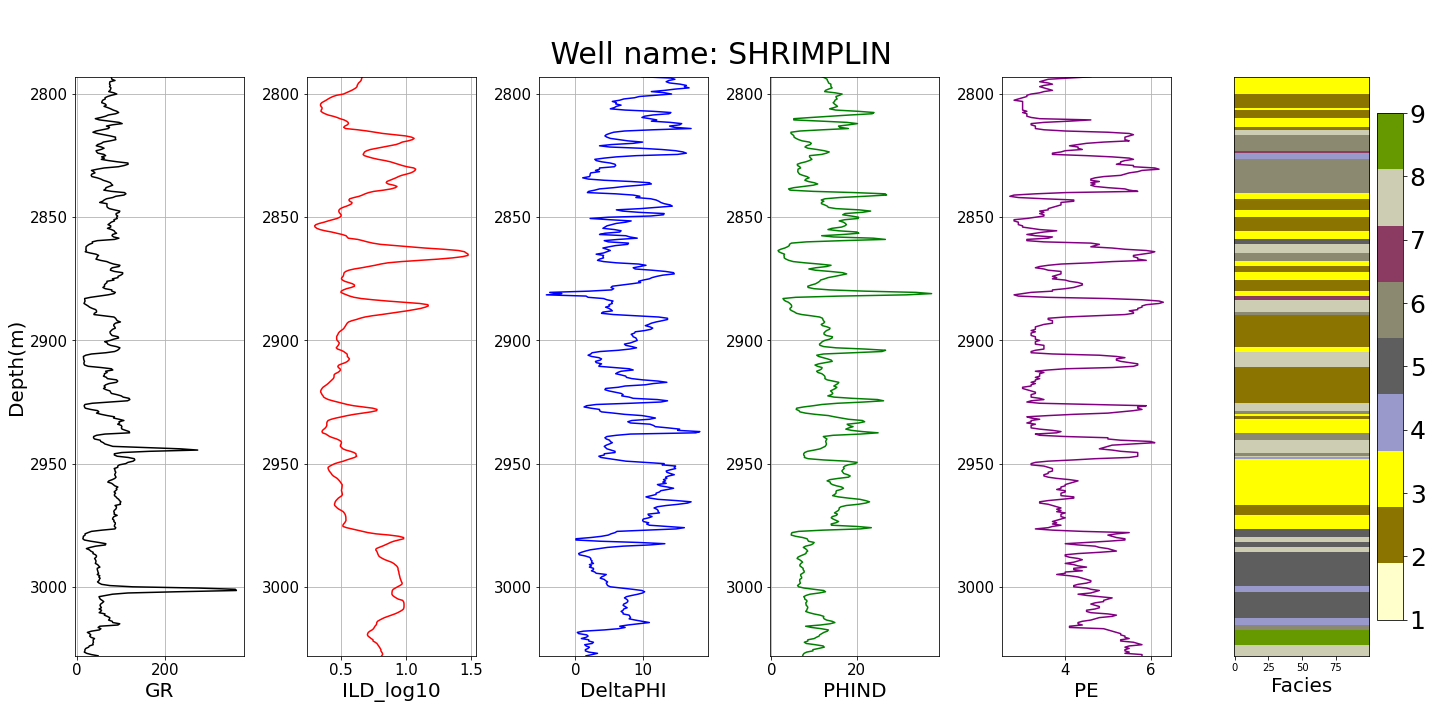

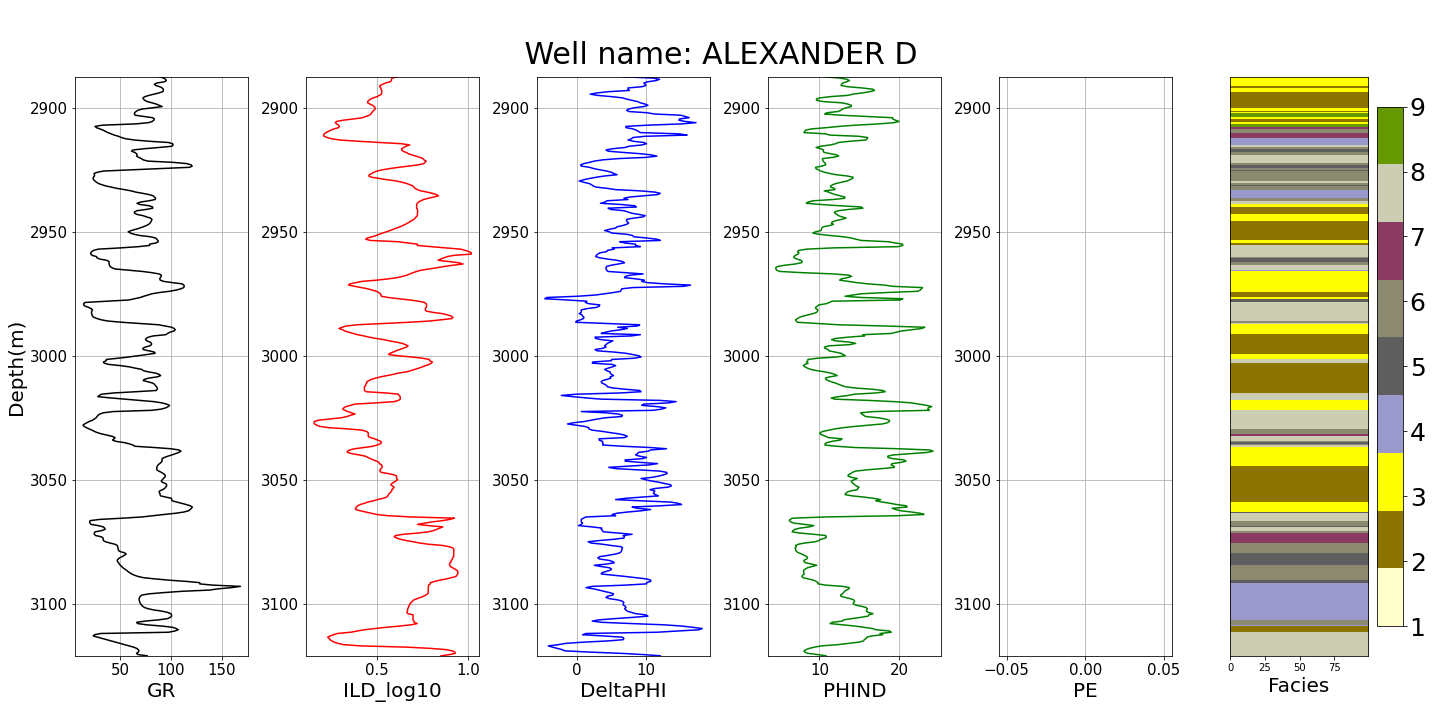

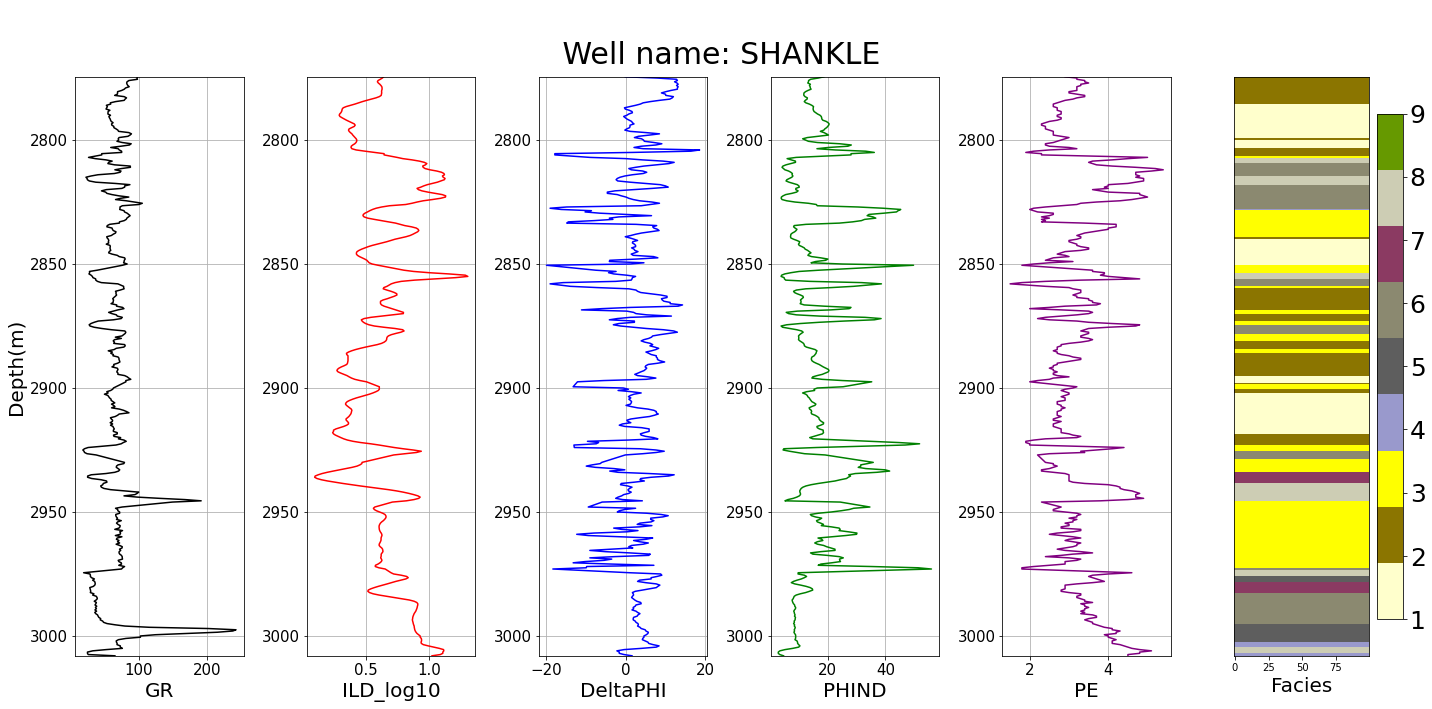

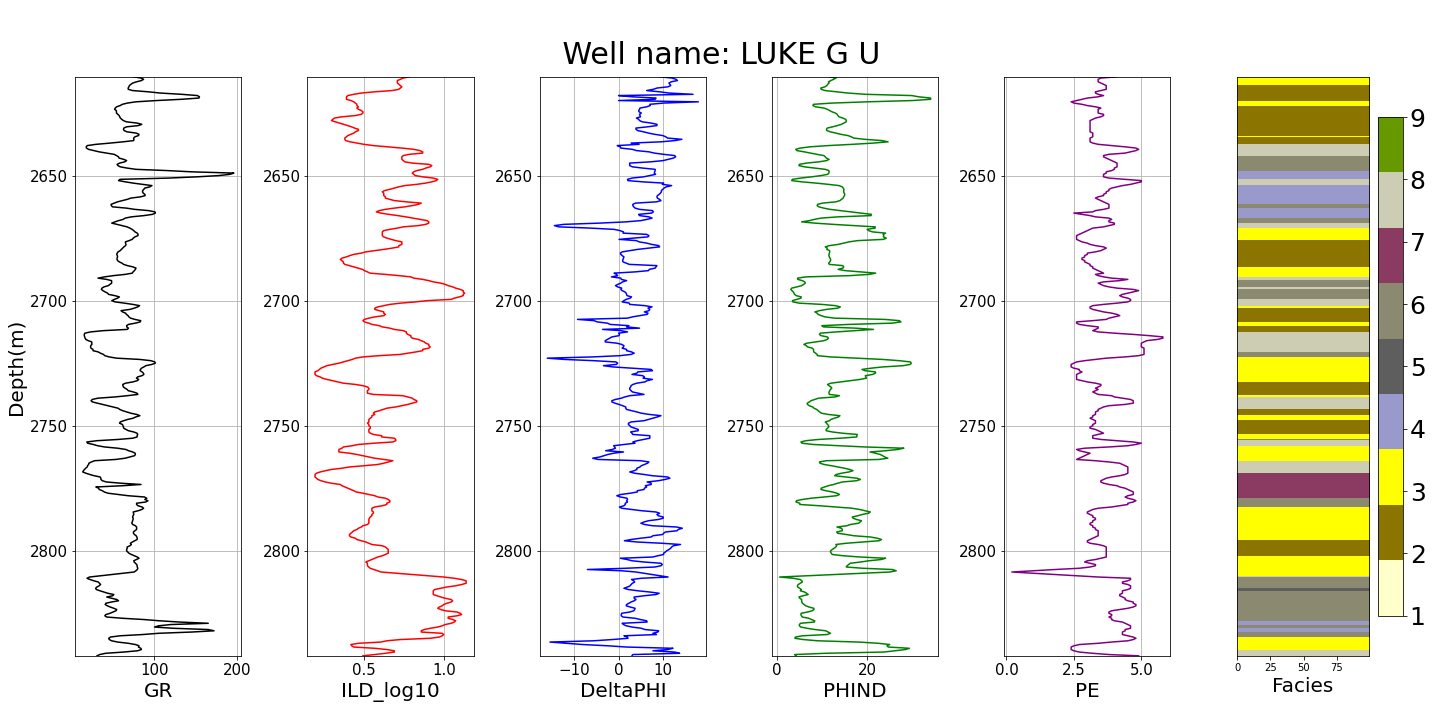

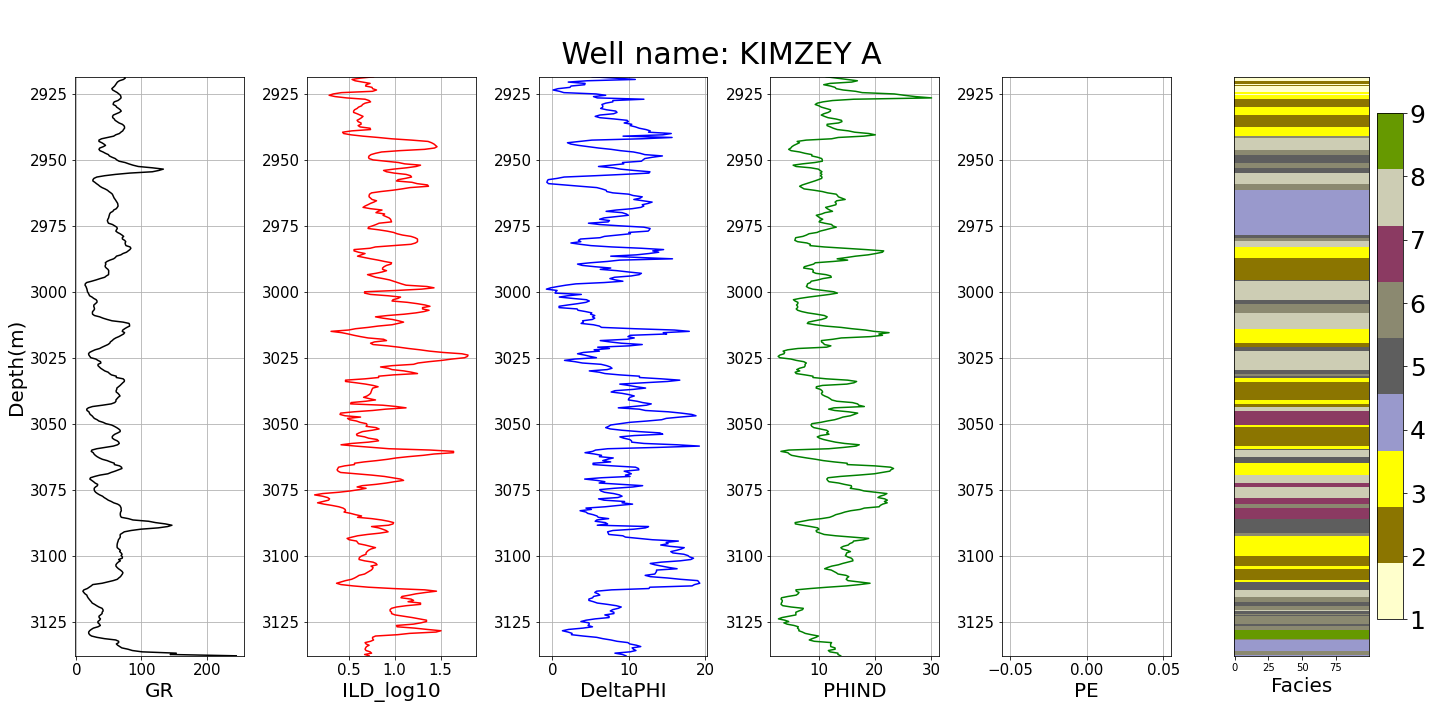

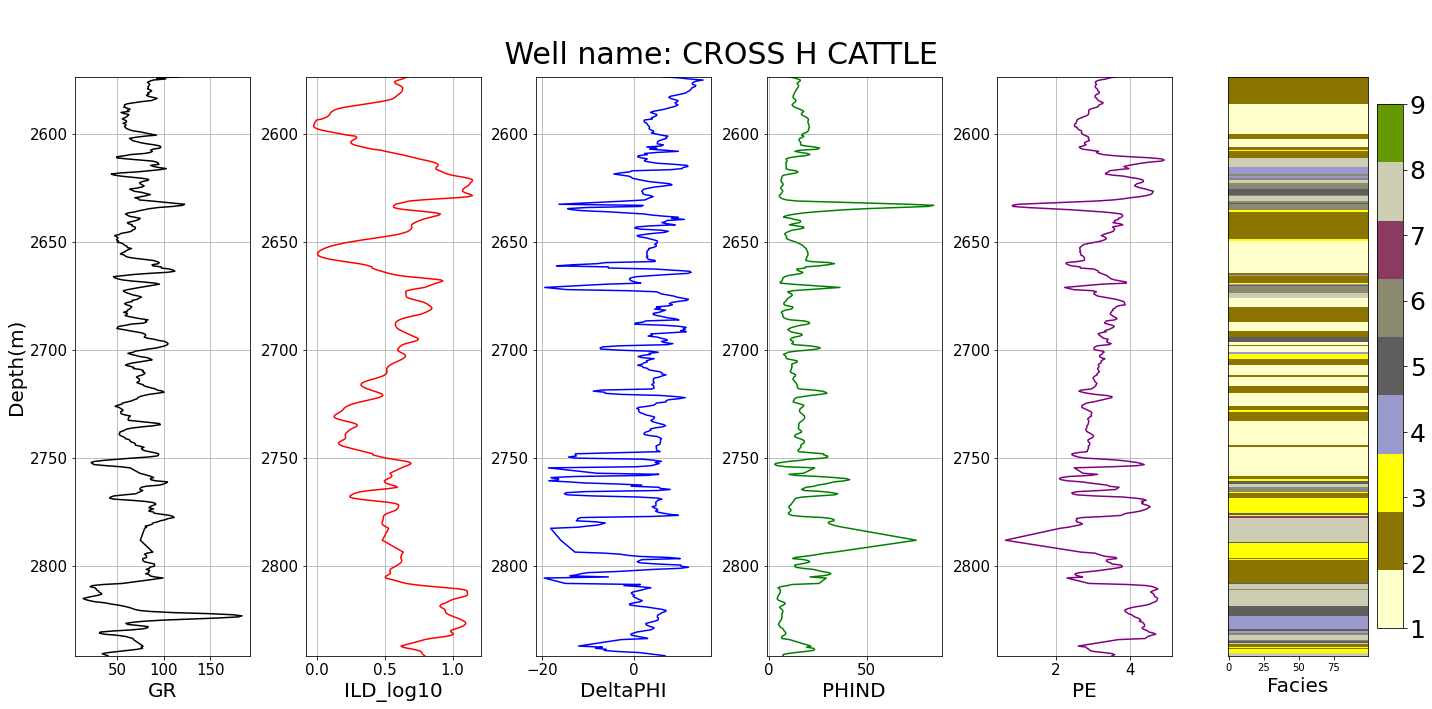

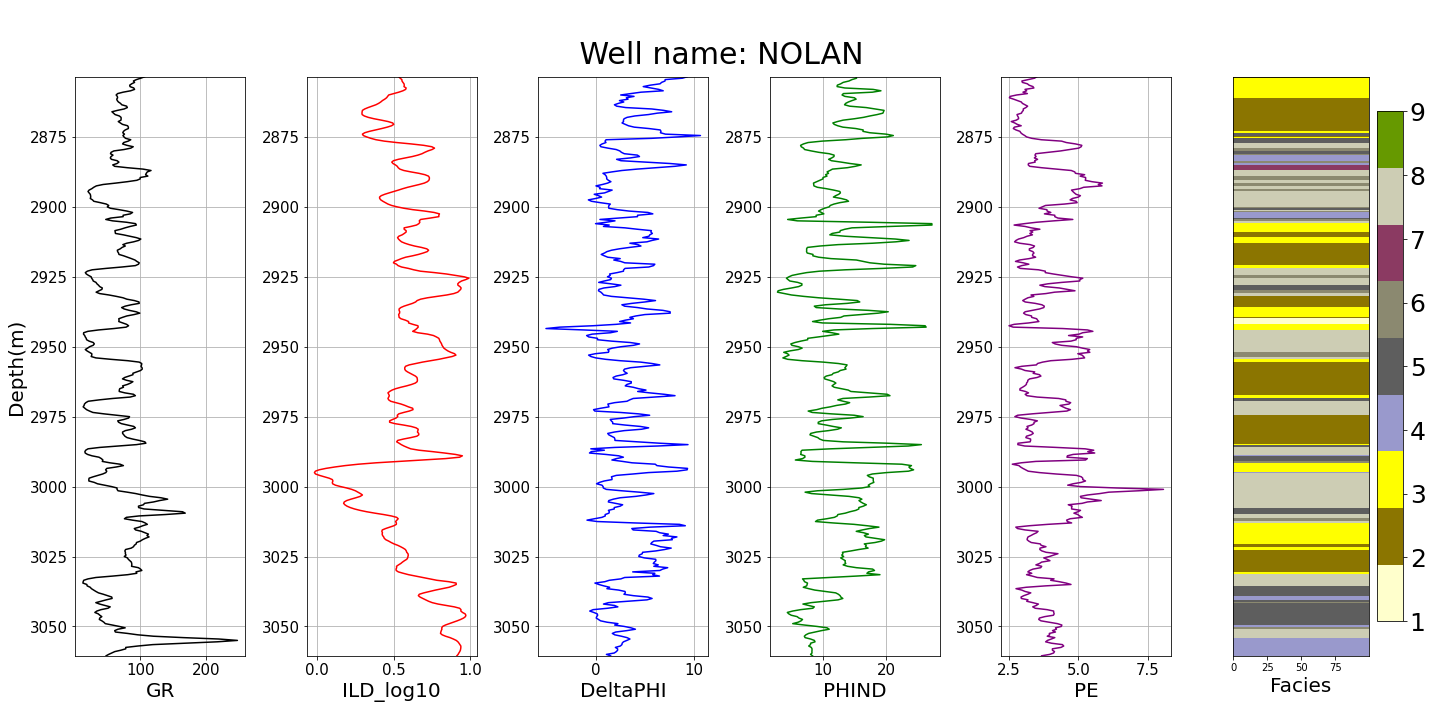

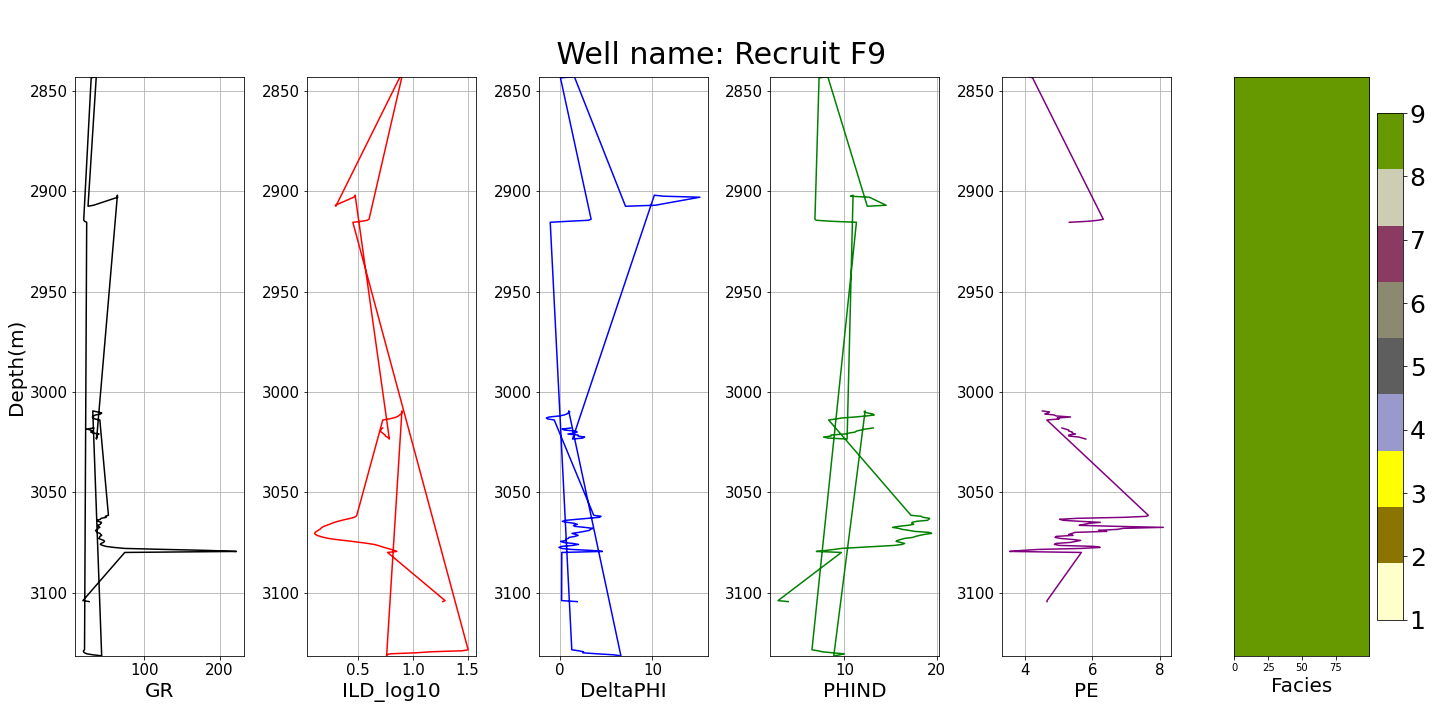

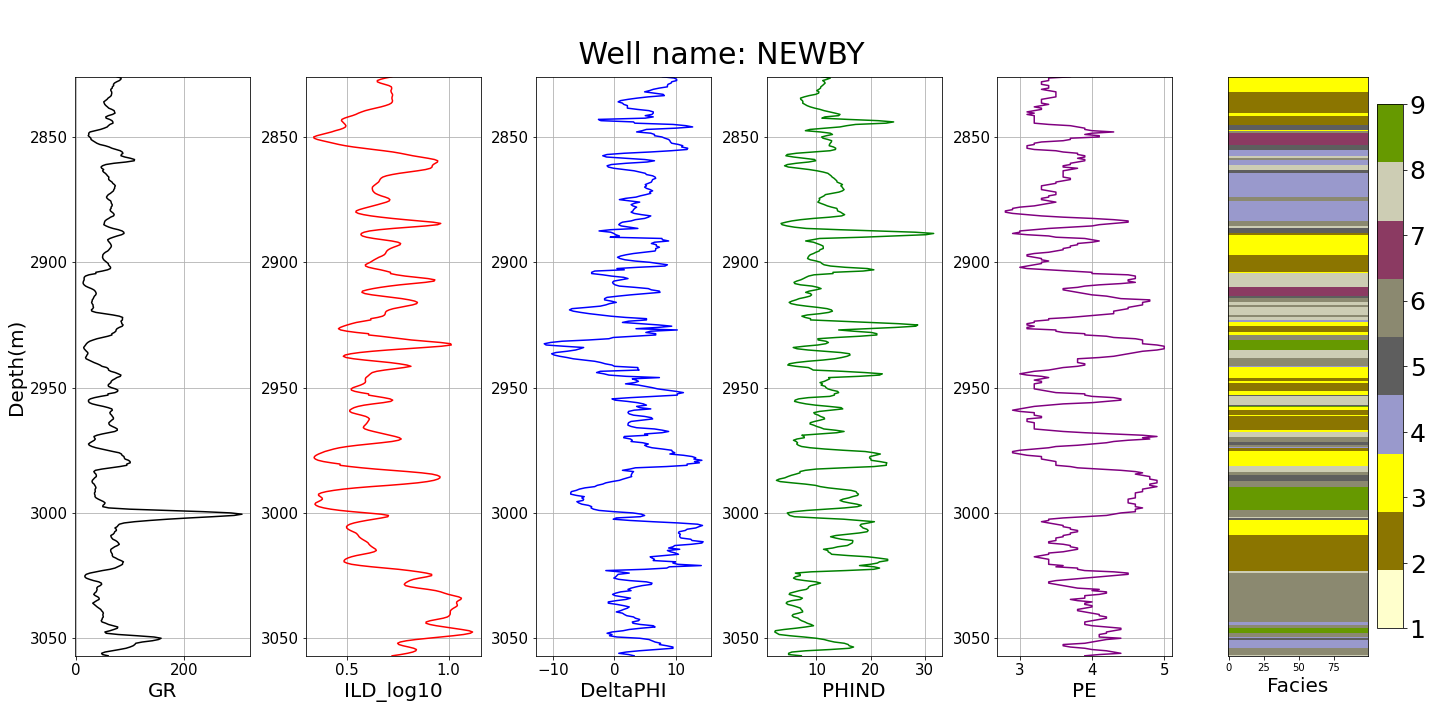

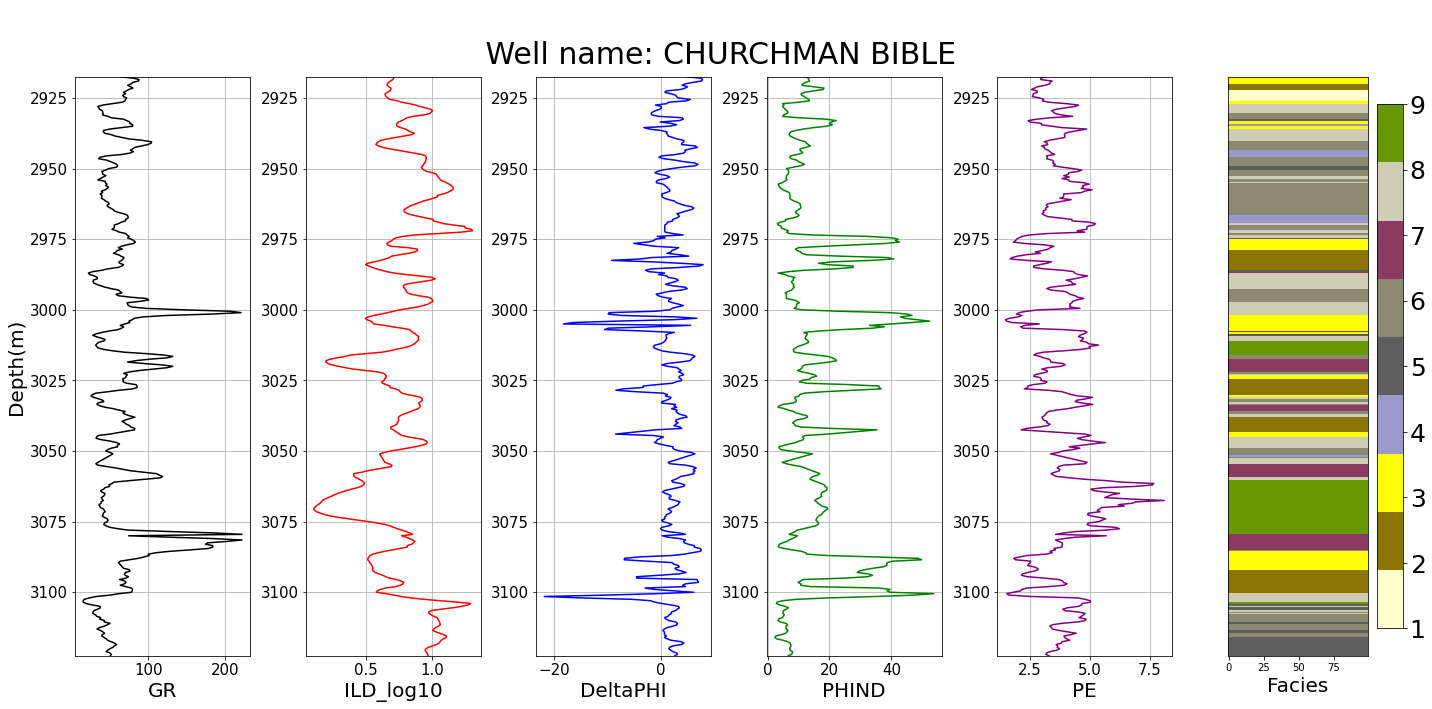

In [1554]:
# display logs for each well
#log_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'Facies']
log_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'Facies']
colormap = ['black', 'red', 'blue', 'green', 'purple']
for df in dflist:
    well_name = df['Well Name'].unique()[0]
    displayLogs(df, well_name, log_names, colormap)

From the plots we can see that Well Recruit F9 looks very suspicious. We will drop this well in its entirety. The other wells look normal except that PE log is missing in two wells 'ALEXANDER D' AND 'KIMZEY A'. We will handle the missing data in session 2.
Now let's remove well 'Recruit F9'.

In [1555]:
# Remove well "Recruit F9"
data = data.loc[data['Well Name'] != 'Recruit F9']

wellnames = np.delete(wellnames, np.where(wellnames == 'Recruit F9'))
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,newby,churchman_bible]

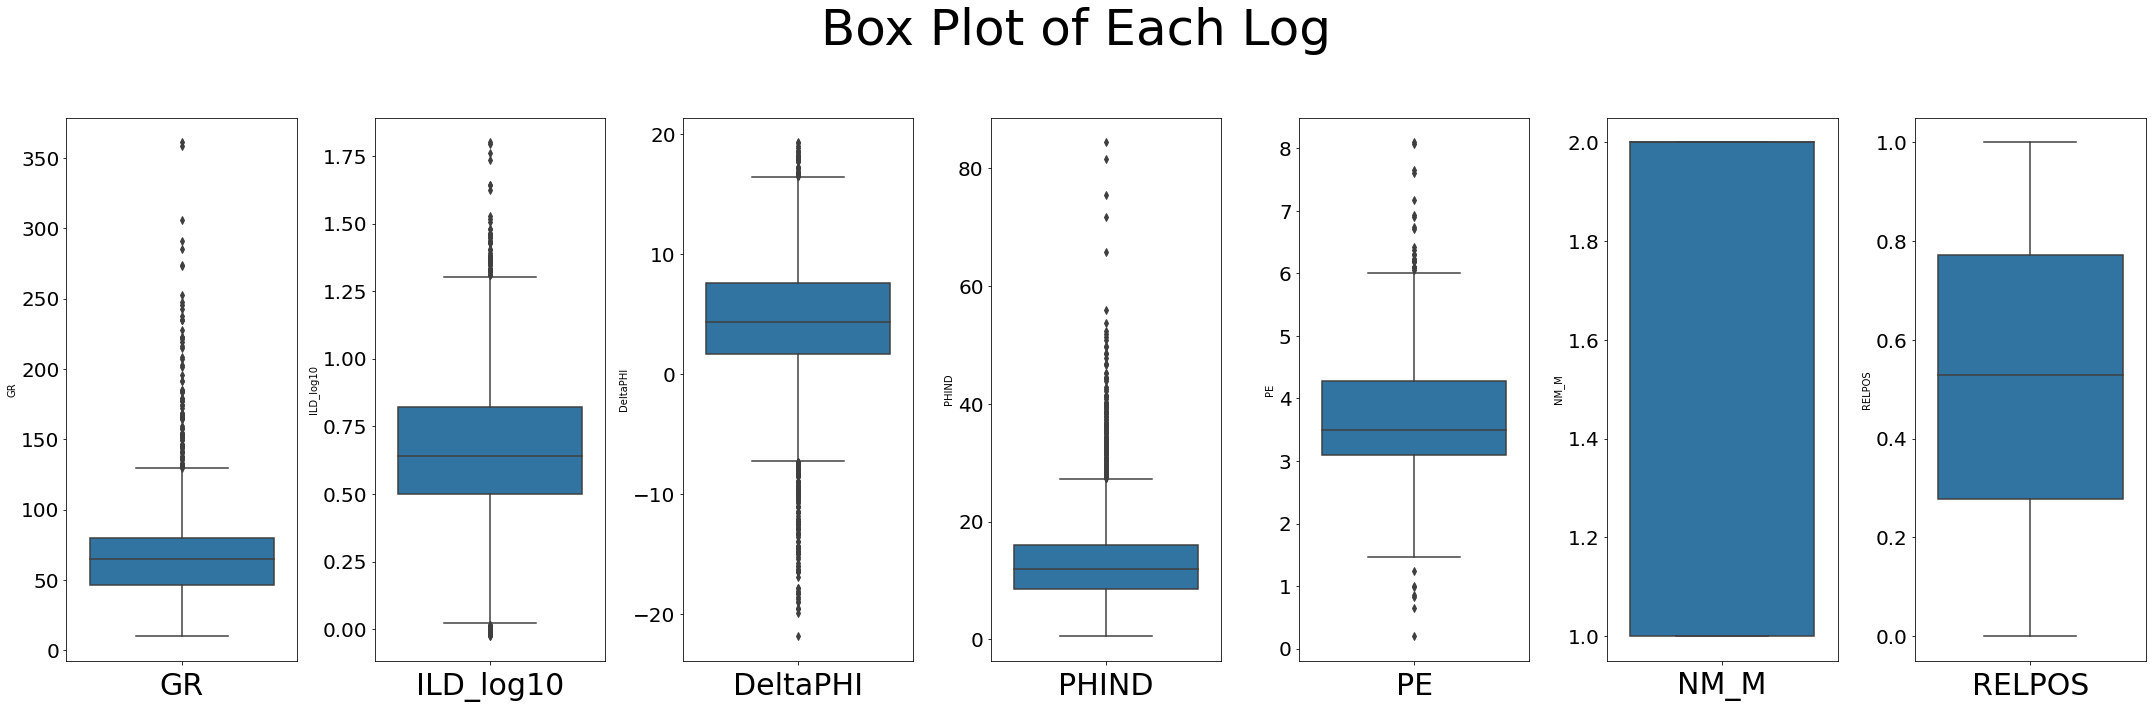

In [1556]:
# Make boxplot for each log curve
fig, axes = plt.subplots(1, len(lognames), figsize=(30,10))
for i, ax in enumerate(axes.flat):
    sns.boxplot(data=data, y=data.iloc[:,i+4], ax=axes[i], orient='v')
    ax.set_xlabel(data.columns[i+4], fontsize=30)
    ax.tick_params(axis='y', labelsize = 20)
fig.suptitle('Box Plot of Each Log\n', fontsize=50)
plt.tight_layout()

All 5 logs are showing some outliers. But the outliers are not necessarily bad data. Let's make the box plots for each well to check if any of the wells have "bad" data.

In [1557]:
#plot each log curve to find where the outliers occur

def log_boxplot(welldfs, welllist, log):
    fig, axes = plt.subplots(1, len(welldfs), figsize=(30,10))
    for i, ax in enumerate(axes.flat):
        sns.boxplot(data=welldfs[i], y=log, ax=axes[i], orient='v')
        #ax.set_xlabel(log, fontsize=30)
        ax.set_title(welllist[i], fontsize=30)
        ax.tick_params(axis='both', labelsize = 30)
    fig.suptitle('\nBox Plot For ' + log + '\n', fontsize=50)
    plt.tight_layout()
    

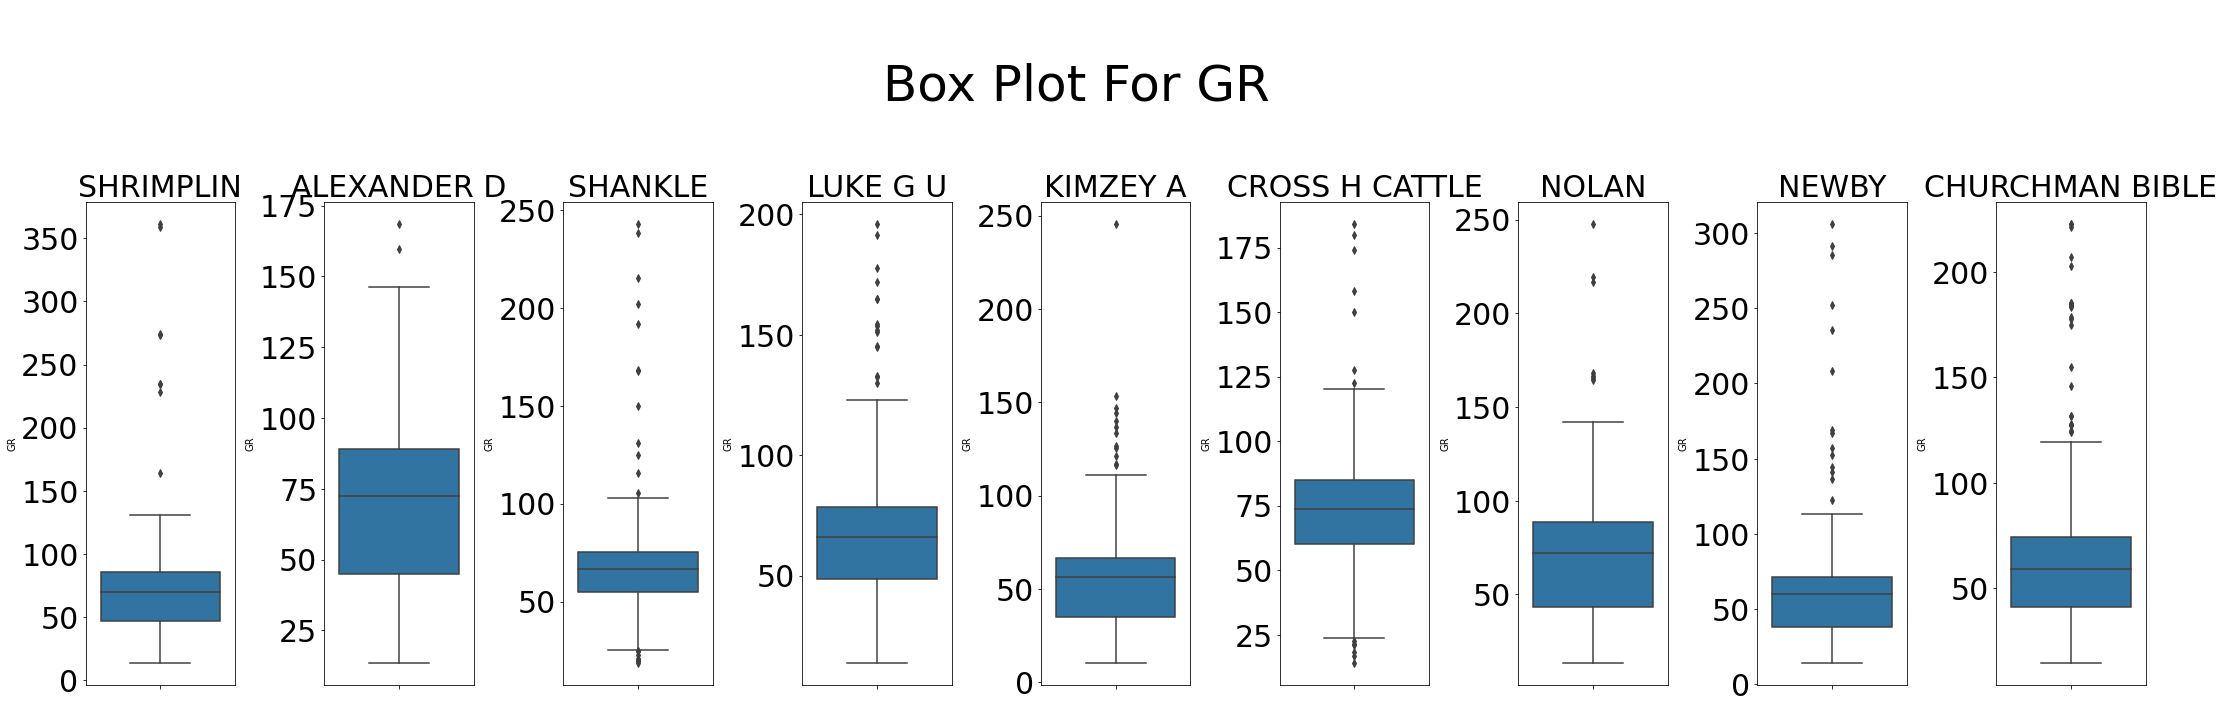

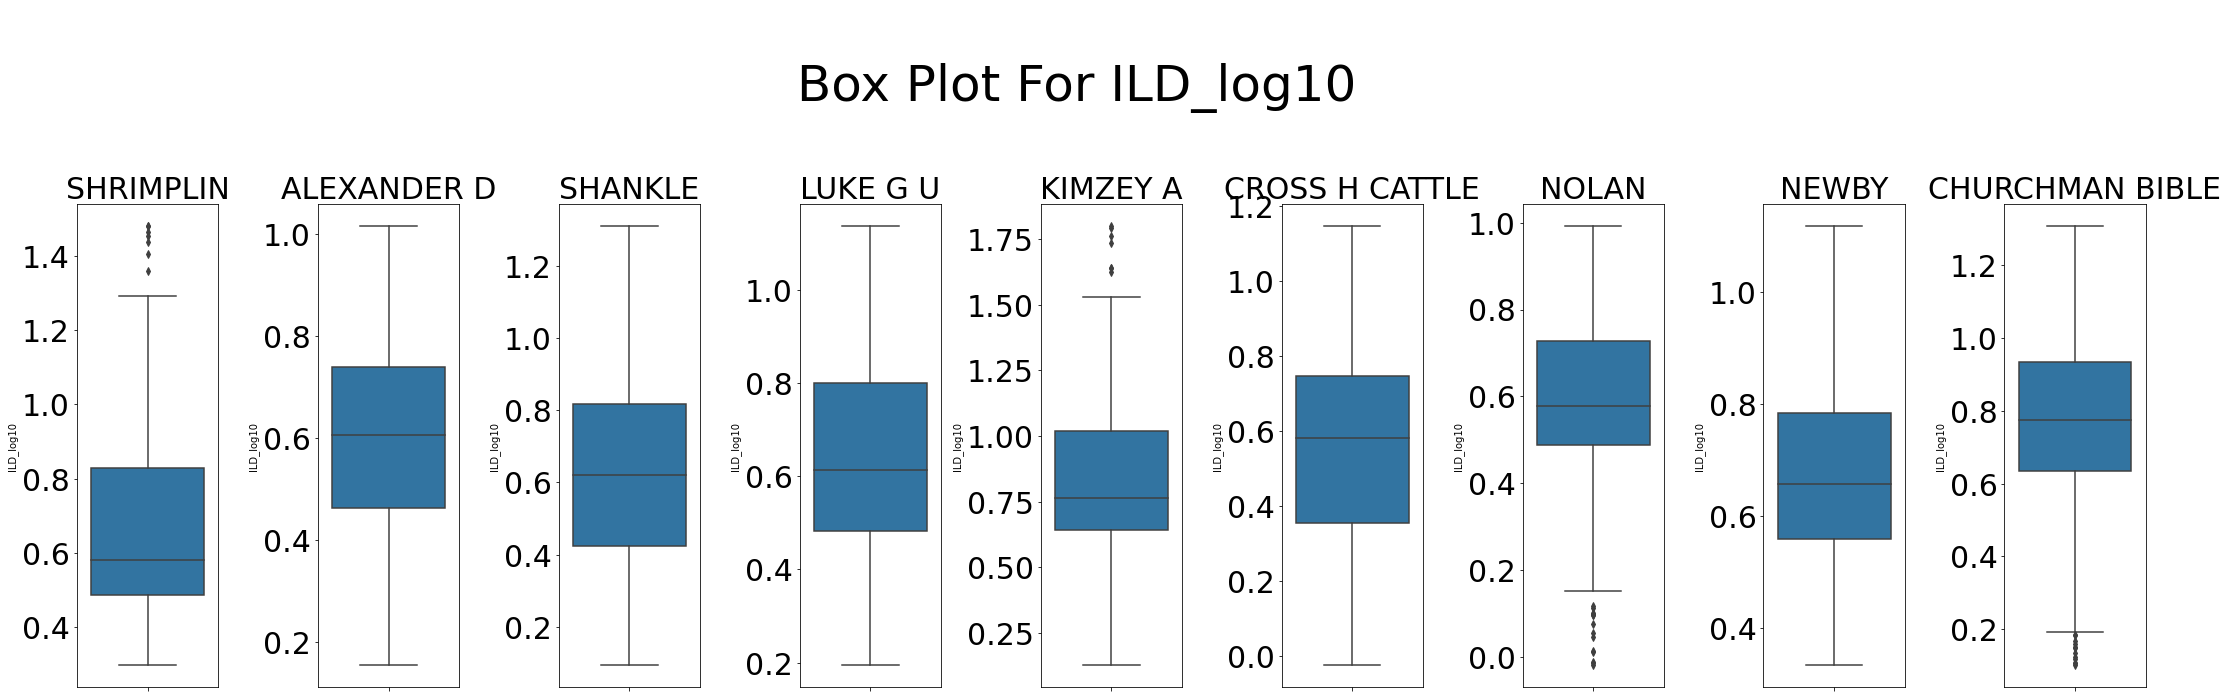

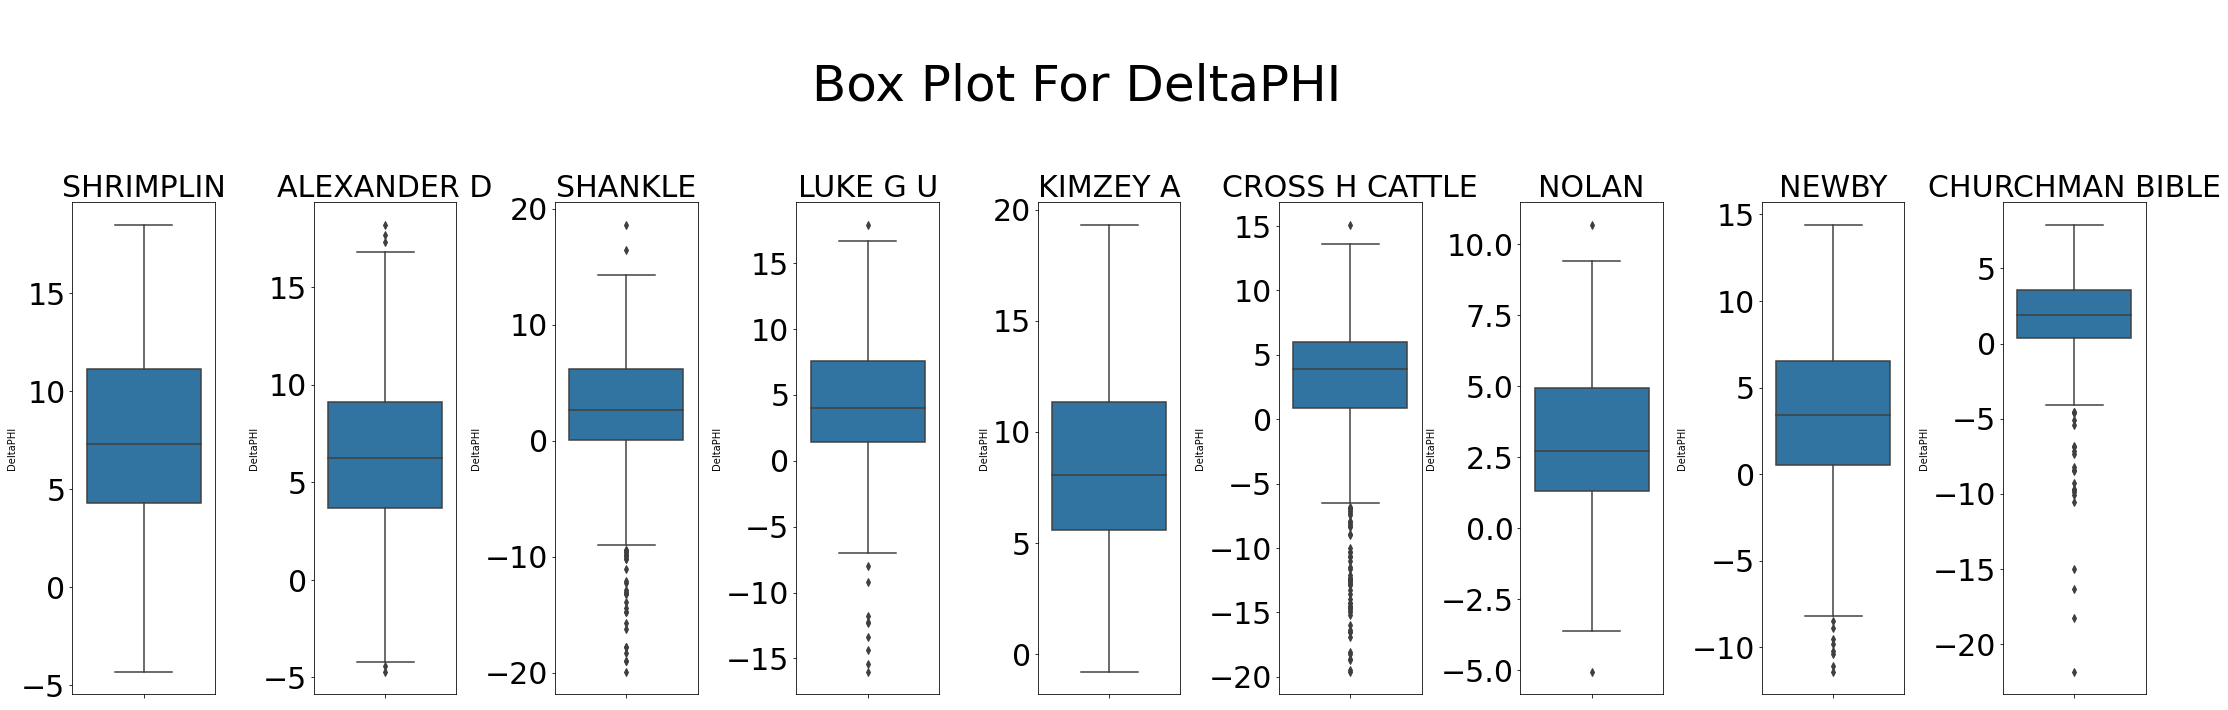

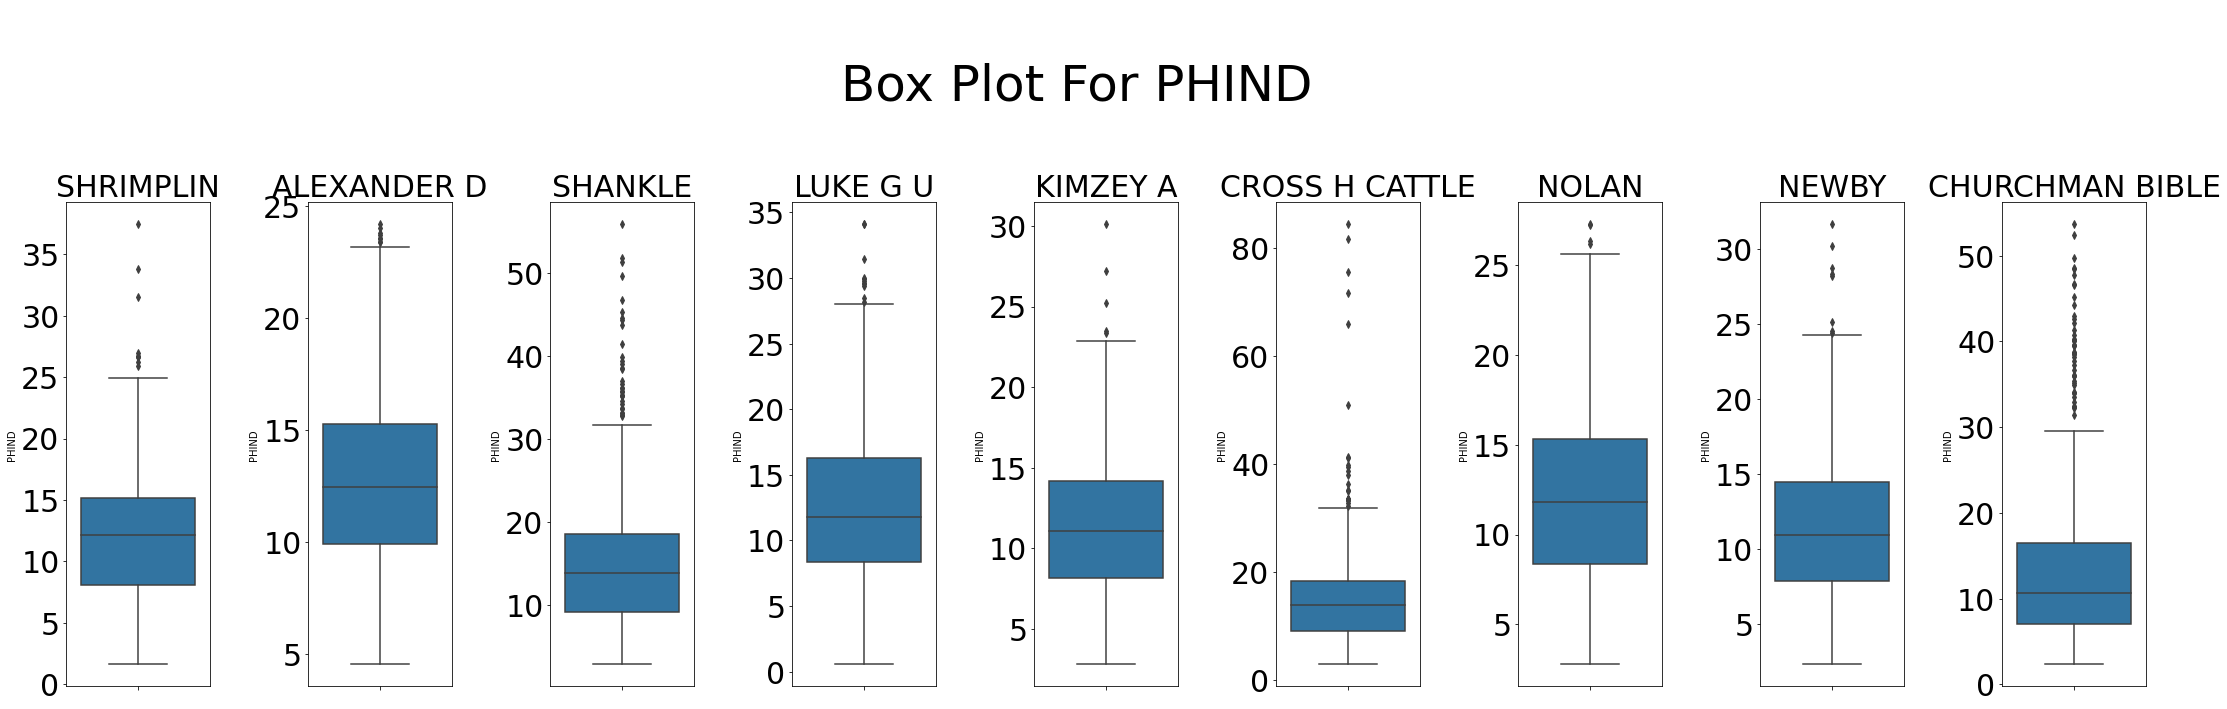

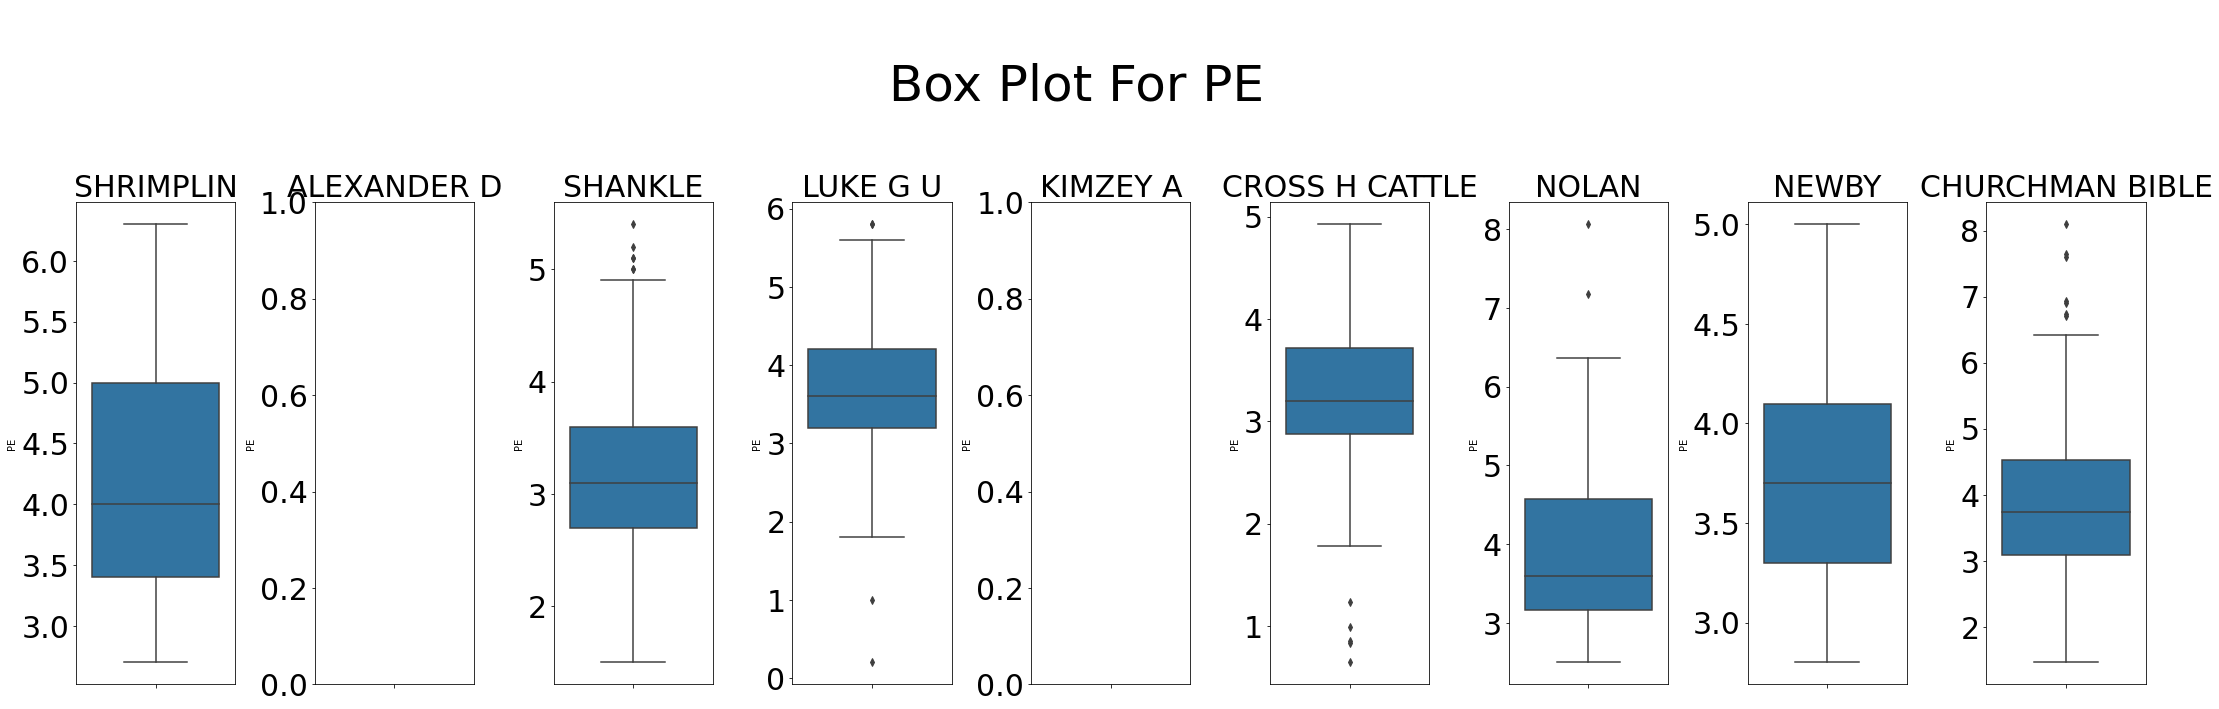

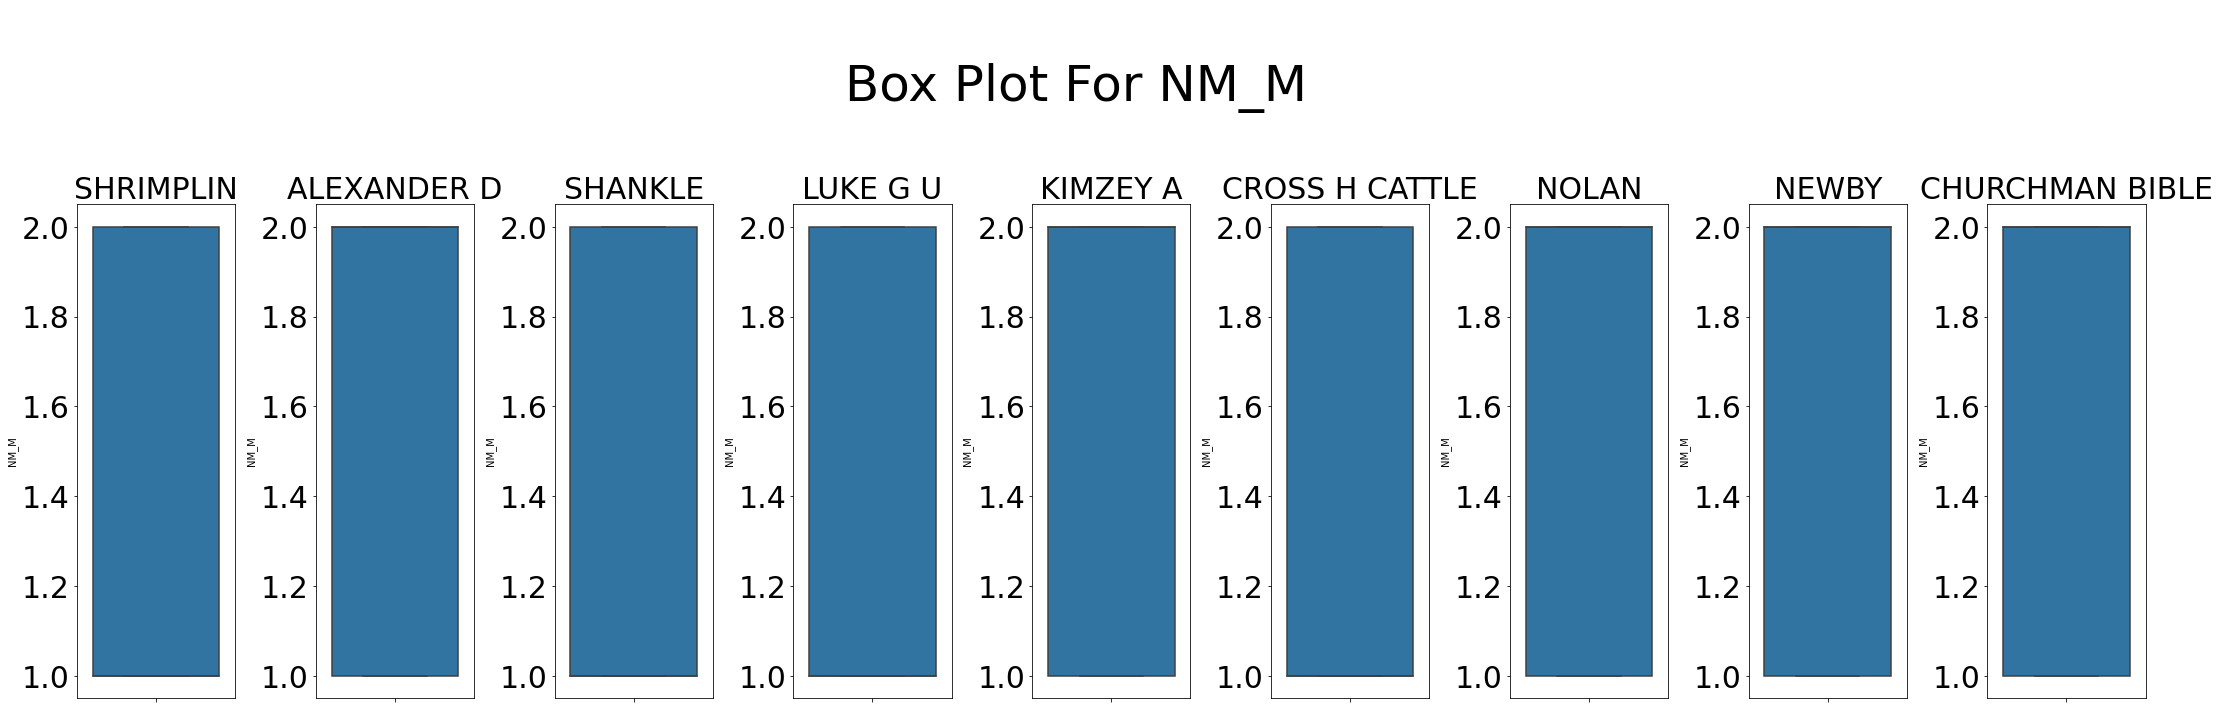

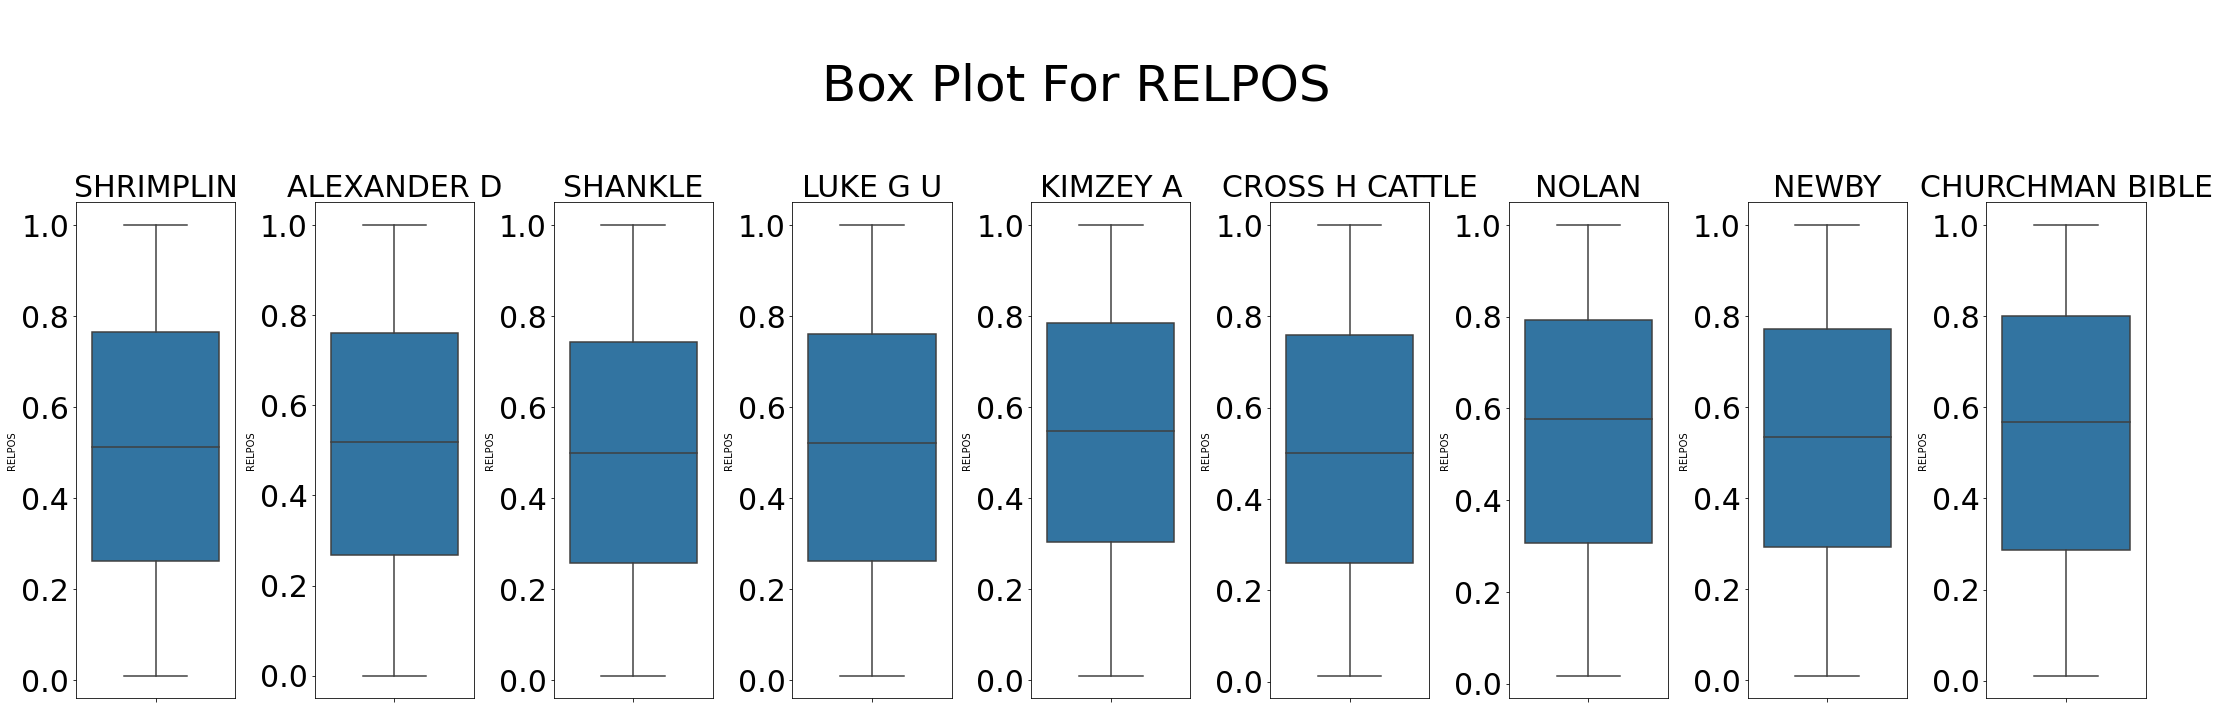

In [1558]:
for log in lognames:    
    log_boxplot(dflist, wellnames, log)

From the boxplots, we can see that most of the log curves are in good shape. In the next section, we will experiment data imputation for the missing PE curves.

# 2 Exploratory Data Analysis

PE is missing in two wells. We have two choices: drop these two wells in their entirety, or, we can try to estimate PE from other logs. If we drop these two wells we will lose 22% of the data which is significant. So in this case we would prefer estimating PE if possible. Now let's first plot the correlation between PE and the other logs and see if we can observe any pattern.

## 2.1 Explore correlation between target feature Facies and PE

Text(0.5, 1.0, 'Heatmap of correlation between features')

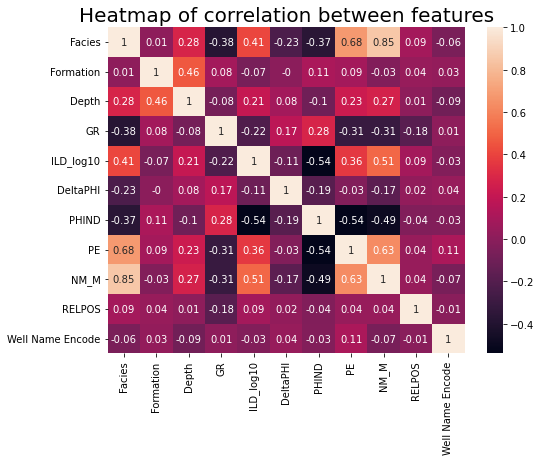

In [1560]:
# plot heatmap for correlation between target feature Facies and PE
data_temp = data.loc[(data['Well Name'] != 'ALEXANDER D') & (data['Well Name'] != 'KIMZEY A')]
data_temp = data_temp.drop(['Well Name'], axis=1)
plt.subplots(figsize=(8,6))
sns.heatmap(np.round(data_num.corr(),2), annot=True)
plt.title('Heatmap of correlation between features', fontsize=20)

There is strong correlation between Facies and PE, therefore we should try to estimate PE for the two wells.

## 2.2 Explore relationship between PE and other logs

In [1477]:
logdata = data[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
logdata.head()

GR  ILD_log10  DeltaPHI   PHIND   PE
0  77.45      0.664       9.9  11.915  4.6
1  78.26      0.661      14.2  12.565  4.1
2  79.05      0.658      14.8  13.050  3.6
3  86.10      0.655      13.9  13.115  3.5
4  74.58      0.647      13.5  13.300  3.4

Text(0.5, 0.98, 'Correlation Among Logs')

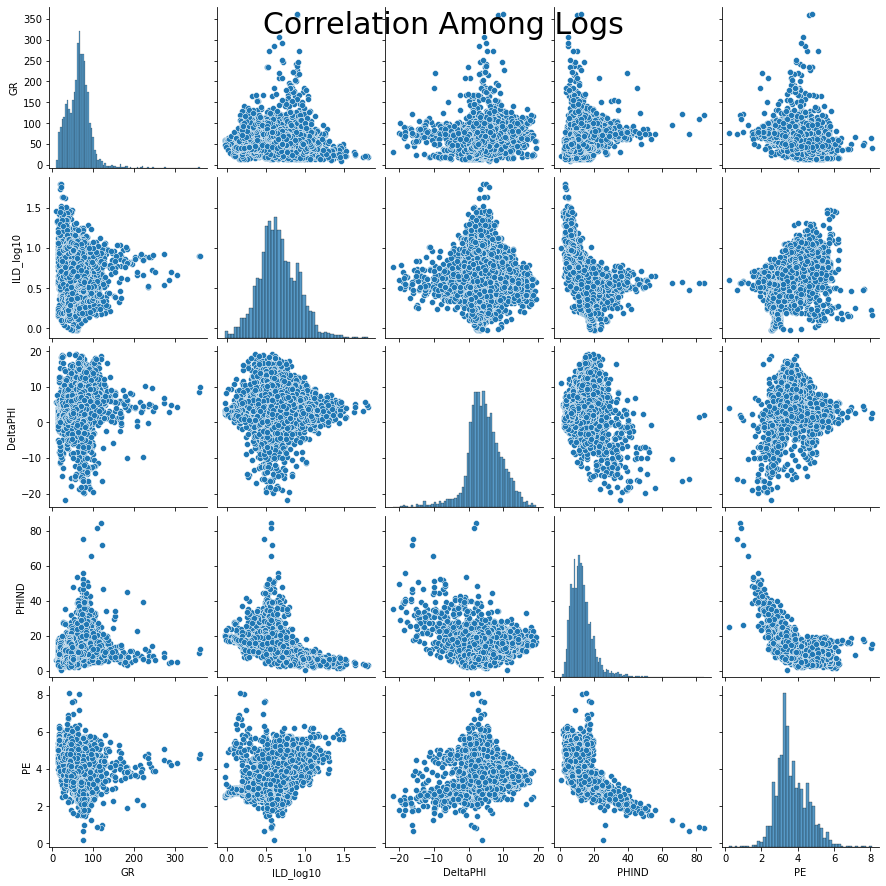

In [1478]:
# we will use pairplot and heatmap to examine the correlation between the log curves, 
# especially between PE and other logs.
_ = sns.pairplot(logdata)
_.fig.suptitle(t='Correlation Among Logs', fontsize=30)

[Text(0.5, 1.0, 'Heatmap of correlation between different logs')]

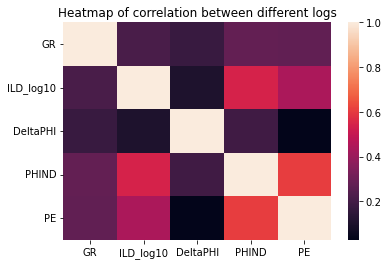

In [1563]:
_ = sns.heatmap(np.abs(logdata.corr()))
_.set(title='Heatmap of correlation between different logs')

From the scatter plots and heatmap we see a good correlation between PE and PHIND. We will try to estimate PE from PHIND.

## 2.3 Estimate missing PE for wells "Alexander D" and "Kimzey A"

We will try to estimate PE using the following two methods:
1. **Polynomial regression** using only one log "PHIND"
2. **Netural network multi-layer regression** using all columns
3. **FancyImpute** using all columns

### 2.3.1 Polynomial Regression using PHIND

In [1480]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [1481]:
PHIND = data.loc[(data['Well Name'] != 'ALEXANDER D') & (data['Well Name'] != 'KIMZEY A'),'PHIND']
PE = data.loc[:, 'PE'].dropna()
print(PHIND.shape)
print(PE.shape)

(3164,)
(3164,)


In [1482]:
X_train, X_test, y_train, y_test = train_test_split(PHIND, PE, test_size=0.3, random_state=101)

In [1483]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)

X_test=pd.DataFrame(X_train)
y_test=pd.DataFrame(y_train)

In [1484]:
poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)
y_selfpredict_poly = poly_reg_model.predict(X_train_poly)

In [1485]:
def calculate_error(real, predict):
    print('MAE:', metrics.mean_absolute_error(real, predict))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(real, predict)))
    print('R2 score:', metrics.r2_score(real, predict))
    

In [1486]:
calculate_error(y_train, y_selfpredict_poly)

MAE: 0.49291367934018543
RMSE: 0.6630699262351235
R2 score: 0.38605263196822315


In [1487]:
def check_scatterplot(x, y, xlabel, ylabel, title):
    plt.scatter(x, y, s=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(y, y, color='red')

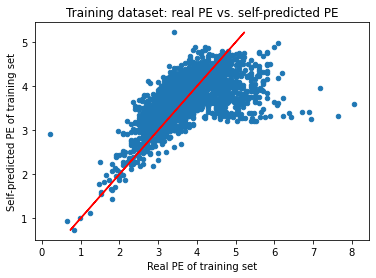

In [1488]:
#plot the train split (blue dots) and the predicted y of the X_train
check_scatterplot(y_train,
                  y_selfpredict_poly, 
                  'Real PE of training set', 
                  'Self-predicted PE of training set',
                  'Training dataset: real PE vs. self-predicted PE')

Summary of polynomial regression:
1. MSE is 0.44, R2 score is 0.38. Not a good model because it explains less than half of the data.
2. The scatterplot shows there are a lot of predicted PE data points that don't match the real data.

### 2.3.2 Use Neural Network Multi-layer Regression with the whole suite of logs 

Even though there is no obvious correlation between PE and the logs other than PHIND, we'll still try to use all logs to predict PE, and compare its performance with the polynomial model.

In [1489]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [1490]:
data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [1491]:
# first let's convert formation tops and well names to integers so that we can also use this information 
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
formation_enc = enc.fit_transform(data['Formation'])
data.loc[:, 'Formation'] = formation_enc

well_name_enc = enc.fit_transform(data['Well Name'])
data.loc[:, 'Well Name Encode'] = well_name_enc
data.head()

Facies  Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3          1  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3          1  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3          1  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3          1  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3          1  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  Well Name Encode  
0  4.6     1   1.000                 8  
1  4.1     1   0.979                 8  
2  3.6     1   0.957                 8  
3  3.5     1   0.936                 8  
4  3.4     1   0.915                 8

In [1492]:
# Store 10 features in 7 wells as DataFrame LOGS
LOGS = data.loc[(data['Well Name'] != 'ALEXANDER D') & (data['Well Name'] != 'KIMZEY A'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS', 'Well Name Encode']]

# Store PE values in 7 wells as DataFrame PE
PE = data.loc[:, 'PE']
PE.dropna(inplace=True)
print(LOGS.shape)
print(PE.shape)

(3164, 10)
(3164,)


In [1493]:
# scale the features
scaler = StandardScaler()
LOGS_scaled = scaler.fit_transform(LOGS)
LOGS_scaled.shape

(3164, 10)

In [1494]:
X_train, X_test, y_train, y_test = train_test_split(LOGS_scaled, PE, test_size=0.3, random_state=101)

In [1495]:
NNmodel = MLPRegressor()
NNmodel.fit(X_train, y_train)
y_train_predict_NN = NNmodel.predict(X_train)

C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [1496]:
NNmodel.score(X_train, y_train) # examine accuracy

0.8189553120160014

In [1497]:
calculate_error(y_train, y_train_predict_NN)

MAE: 0.2597881409609489
RMSE: 0.36006976329165613
R2 score: 0.8189553120160014


The Neural Network Multi-layer regressor produces a better performance than polynomial regression model (MSE 0.16 vs. 0.44). Its accuracy is 0.77.

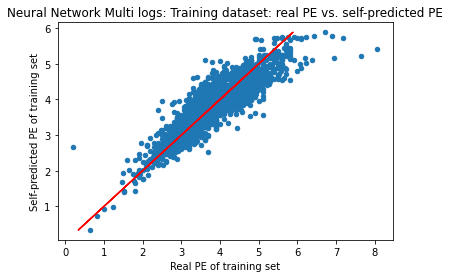

In [1498]:
#plot the train split (blue dots) and the predicted y of the X_train
check_scatterplot(y_train,
                  y_train_predict_NN, 
                  'Real PE of training set', 
                  'Self-predicted PE of training set',
                  'Neural Network Multi logs: Training dataset: real PE vs. self-predicted PE')

The scatter plot also demonstrates a better fit for the training set comparing to the polynomial regression model. Now let's apply the NN model to the test set. 

In [1499]:
y_test_predict_NN = NNmodel.predict(X_test)
calculate_error(y_test, y_test_predict_NN)

MAE: 0.26921065413388945
RMSE: 0.38288693391833156
R2 score: 0.8148951780920415


We get similar accuracy with the test data set - a consistent performance. Net we will use this model to estimate PE log for the two wells.

In [1500]:
# well Amexander D
Alex = data.loc[(data['Well Name'] == 'ALEXANDER D'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS', 'Well Name Encode']]
scaler = StandardScaler()
Alex = scaler.fit_transform(Alex)
Alex_PE_predict = NNmodel.predict(Alex)

In [1501]:
# well Kimzey A
Kimz = data.loc[(data['Well Name'] == 'KIMZEY A'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS', 'Well Name Encode']]
scaler = StandardScaler()
Kimz = scaler.fit_transform(Kimz)
Kimz_PE_predict = NNmodel.predict(Kimz)

In [1502]:
# replace the Null data with the predicted PE for both wells
data_NNimputed = data.copy()
data_NNimputed.loc[data['Well Name']=='ALEXANDER D', 'PE'] = Alex_PE_predict
data_NNimputed.loc[data['Well Name']=='KIMZEY A', 'PE'] = Kimz_PE_predict

In [1503]:
#alexander_d = data_NNimputed.loc[data['Well Name']=='ALEXANDER D']
#kimzey_a = data_NNimputed.loc[data['Well Name']=='KIMZEY A']

In [1540]:
# display logs for each well
#dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,newby,churchman_bible]
#for df in dflist:
#    displayLogs(df, df['Well Name'].unique()[0], log_names, colormap)

### 2.3.3 Use FancyImpute to handle the missing PE data in the two wells

In order to compare the performance of various imputing methods with the above Neural Network method, we will use the same test dataset. Imputing requires missing data in the input dataset, so we will do following steps:
1. Make a copy of the pre-split dataset (7 wells), replace the PE values in the test dataset with NULL values. Note that the features have to be scaled.
2. Impute with the chosen method.
3. Extract the imputed PE values and compare with the real PE (y_test) and calculate the errors.
4. Choose the best impute method based on the error scores, and use it to impute PE for the two wells where PE is missing

<h4> Prepare the input dataset </h4>

In [1505]:
# create a new DataFrame 'LOGS_forImpute' that contains the 10 features and PE from 7 wells
# this dataset contains data before train_test_split, and it is after scaling
LOGS_forImpute = pd.DataFrame(LOGS_scaled, index=LOGS.index, columns=LOGS.columns).copy()
LOGS_forImpute = pd.concat([LOGS_forImpute, PE], axis=1)

# replace the PE values in the test split with NULL values before imputing
y_test_index = y_test.index
LOGS_forImpute.loc[y_test_index, 'PE'] = np.nan

<h4> We will first write a function that imputes the PE data in the test split and return its performance scores. Then we try different impute functions. </h4>

In [1506]:
def impute(method, data, y_test):
    # impute PE for the test split
    imputed = method.fit_transform(data)
    
    # convert imputed data back to DataFrame
    imputed_df = pd.DataFrame(imputed, index=data.index, columns=data.columns)

    # extract the imputed PE values for the test split
    y_test_imputed = imputed_df.loc[y_test_index]['PE']

    # compare y_tesy_test_imputedt and y_test_impute
    calculate_error(y_test, y_test_imputed)
    return y_test_imputed

In [1507]:
# first try KNN method
from fancyimpute import KNN
knn_imputer = KNN()
y_test_imputed = impute(knn_imputer,LOGS_forImpute,y_test)

Imputing row 1/3164 with 0 missing, elapsed time: 1.352
Imputing row 101/3164 with 0 missing, elapsed time: 1.352
Imputing row 201/3164 with 1 missing, elapsed time: 1.352
Imputing row 301/3164 with 1 missing, elapsed time: 1.352
Imputing row 401/3164 with 1 missing, elapsed time: 1.368
Imputing row 501/3164 with 0 missing, elapsed time: 1.368
Imputing row 601/3164 with 0 missing, elapsed time: 1.368
Imputing row 701/3164 with 0 missing, elapsed time: 1.368
Imputing row 801/3164 with 0 missing, elapsed time: 1.368
Imputing row 901/3164 with 0 missing, elapsed time: 1.368
Imputing row 1001/3164 with 0 missing, elapsed time: 1.368
Imputing row 1101/3164 with 0 missing, elapsed time: 1.368
Imputing row 1201/3164 with 0 missing, elapsed time: 1.383
Imputing row 1301/3164 with 0 missing, elapsed time: 1.383
Imputing row 1401/3164 with 0 missing, elapsed time: 1.383
Imputing row 1501/3164 with 0 missing, elapsed time: 1.383
Imputing row 1601/3164 with 0 missing, elapsed time: 1.383
Imputing 

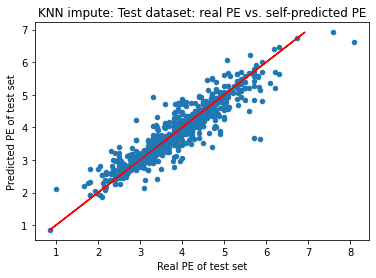

In [1508]:
#plot the train split (blue dots) and the predicted y of the X_train
check_scatterplot(y_test,
                  y_test_imputed, 
                  'Real PE of test set', 
                  'Predicted PE of test set',
                  'KNN impute: Test dataset: real PE vs. self-predicted PE')


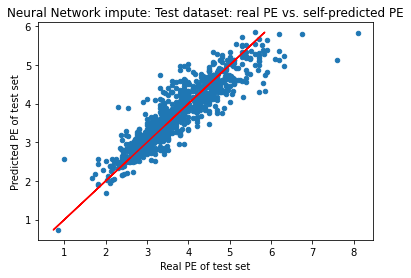

In [1509]:
f2 = check_scatterplot(y_test,
                  y_test_predict_NN, 
                  'Real PE of test set', 
                  'Predicted PE of test set',
                  'Neural Network impute: Test dataset: real PE vs. self-predicted PE')

<h4>KNN impute gives a better result than MLRegressor. Therefore we will use KNN as the final imputing method for the two wells.</h4>

In [1510]:
# drop the Well Name and PE columns from DataFrame "data" and scale the features
LOGS_all_wells = scaler.transform(data.drop(['Well Name', 'PE'], axis=1))

# put PE back to the dataset
LOGS_all_wells = pd.concat([pd.DataFrame(LOGS_all_wells, index=data.index, columns=LOGS.columns),
                            data['PE']], axis=1)

In [1511]:
# impute the missing PE using data from all 9 wells
LOGS_all_wells_KNNimputed = knn_imputer.fit_transform(LOGS_all_wells)

Imputing row 1/4069 with 0 missing, elapsed time: 2.158
Imputing row 101/4069 with 0 missing, elapsed time: 2.158
Imputing row 201/4069 with 0 missing, elapsed time: 2.158
Imputing row 301/4069 with 0 missing, elapsed time: 2.158
Imputing row 401/4069 with 0 missing, elapsed time: 2.158
Imputing row 501/4069 with 1 missing, elapsed time: 2.158
Imputing row 601/4069 with 1 missing, elapsed time: 2.158
Imputing row 701/4069 with 1 missing, elapsed time: 2.174
Imputing row 801/4069 with 1 missing, elapsed time: 2.174
Imputing row 901/4069 with 1 missing, elapsed time: 2.174
Imputing row 1001/4069 with 0 missing, elapsed time: 2.174
Imputing row 1101/4069 with 0 missing, elapsed time: 2.174
Imputing row 1201/4069 with 0 missing, elapsed time: 2.174
Imputing row 1301/4069 with 0 missing, elapsed time: 2.174
Imputing row 1401/4069 with 0 missing, elapsed time: 2.174
Imputing row 1501/4069 with 0 missing, elapsed time: 2.174
Imputing row 1601/4069 with 0 missing, elapsed time: 2.174
Imputing 

In [1512]:
# convert the imputed data back to a dataframe
LOGS_all_wells_KNNimputed_df = pd.DataFrame(LOGS_all_wells_KNNimputed, index=data.index, columns=LOGS_all_wells.columns)
# add Well Name back to the dataframe
LOGS_all_wells_KNNimputed_df['Well Name'] = data['Well Name']
print(LOGS_all_wells_KNNimputed_df.shape)
LOGS_all_wells_KNNimputed_df.head()


(4069, 12)


Facies  Formation     Depth        GR  ILD_log10  DeltaPHI     PHIND  \
0 -0.79261  -0.999612 -3.704093  0.975031  -0.587767  0.327864  0.090633   
1 -0.79261  -0.999612 -3.696214  1.007780  -0.597756  1.346062  0.229399   
2 -0.79261  -0.999612 -3.688335  1.039721  -0.607744  1.488136  0.332940   
3 -0.79261  -0.999612 -3.680456  1.324763  -0.617733  1.275025  0.346817   
4 -0.79261  -0.999612 -3.672577  0.858993  -0.644370  1.180309  0.386312   

       NM_M    RELPOS  Well Name Encode   PE  Well Name  
0 -1.263975  1.622892               5.0  4.6  SHRIMPLIN  
1 -1.263975  1.548891               5.0  4.1  SHRIMPLIN  
2 -1.263975  1.471367               5.0  3.6  SHRIMPLIN  
3 -1.263975  1.397366               5.0  3.5  SHRIMPLIN  
4 -1.263975  1.323366               5.0  3.4  SHRIMPLIN

In [1513]:
# extract imputed PE for the two wells
Alex_PE_predict_KNN = LOGS_all_wells_KNNimputed_df.loc[data['Well Name']=='ALEXANDER D', 'PE']
Kimz_PE_predict_KNN = LOGS_all_wells_KNNimputed_df.loc[data['Well Name']=='KIMZEY A', 'PE']

In [1514]:
# make a copy of the data and replace the Null data with the imputed PE for both wells
data_KNNimputed = data.copy(deep=True)
data_KNNimputed.loc[data['Well Name']=='ALEXANDER D', 'PE'] = Alex_PE_predict_KNN
data_KNNimputed.loc[data['Well Name']=='KIMZEY A', 'PE'] = Kimz_PE_predict_KNN

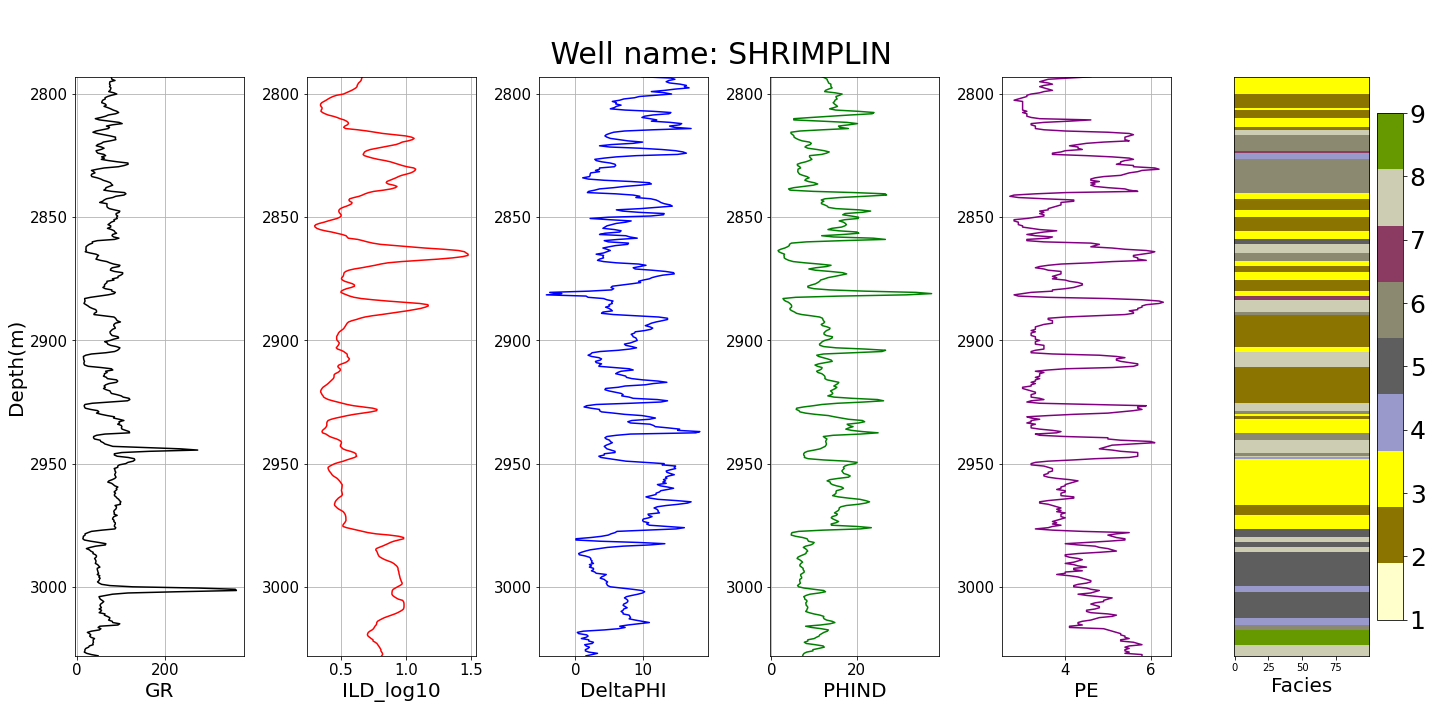

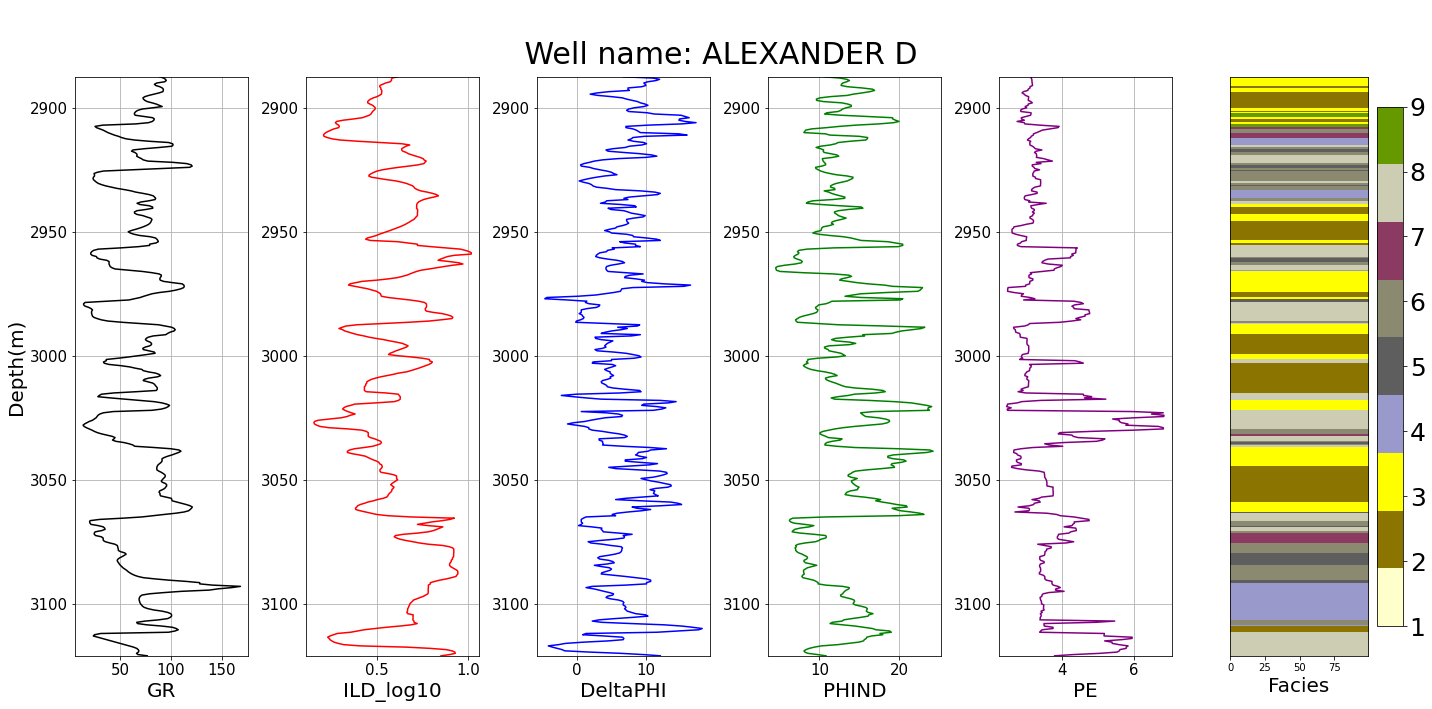

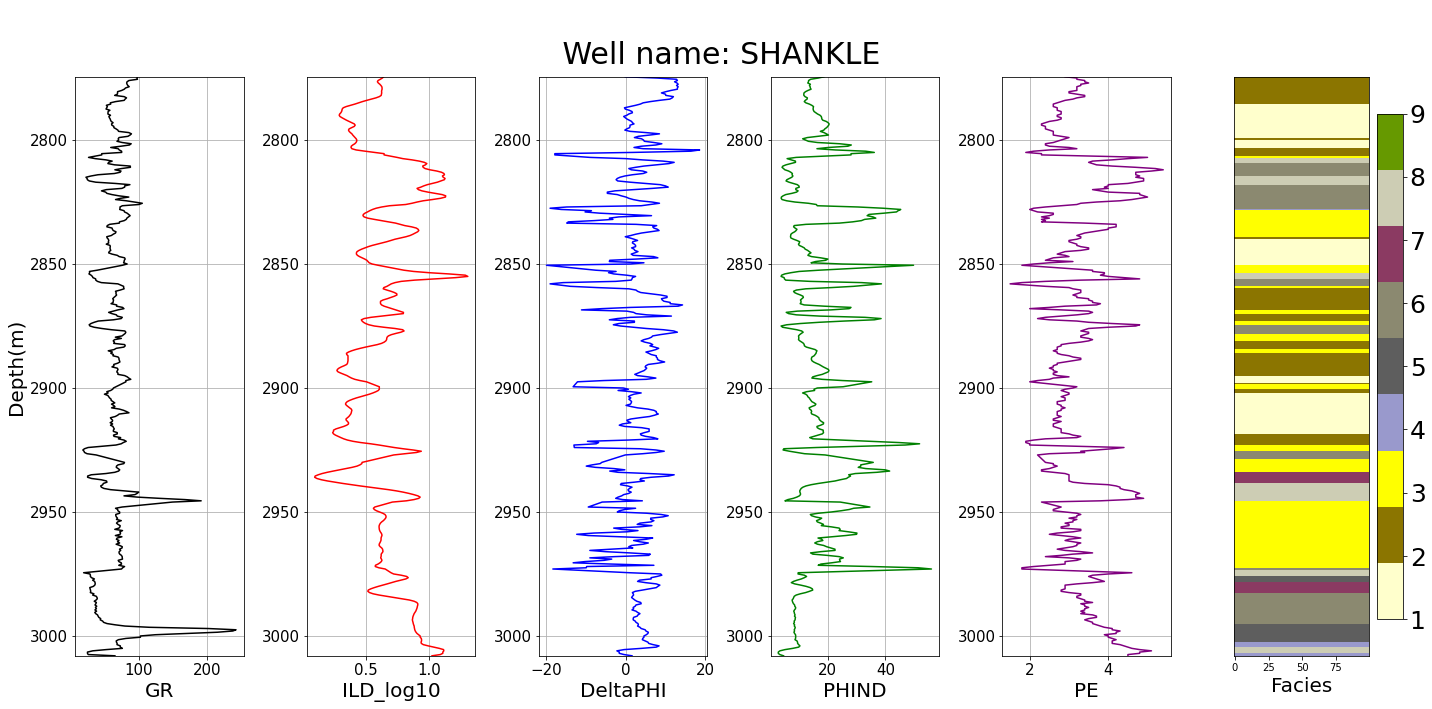

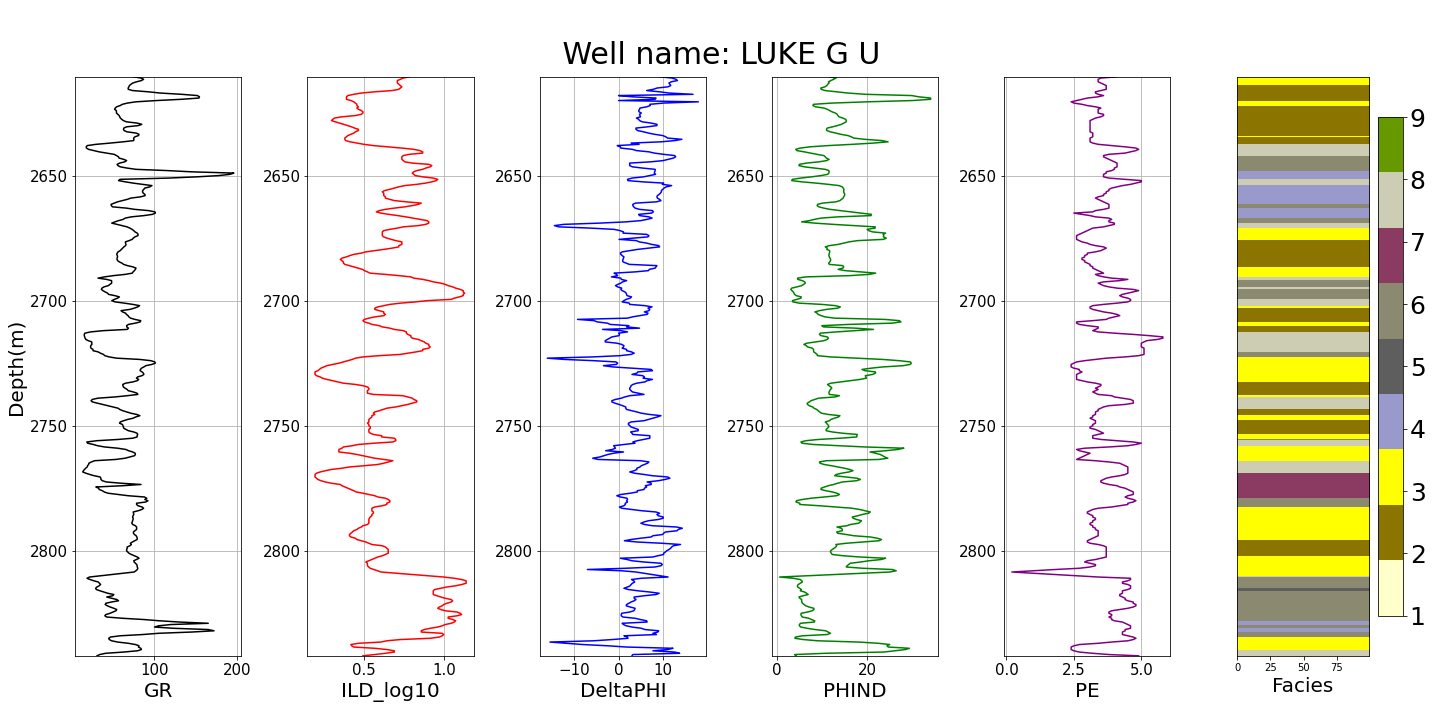

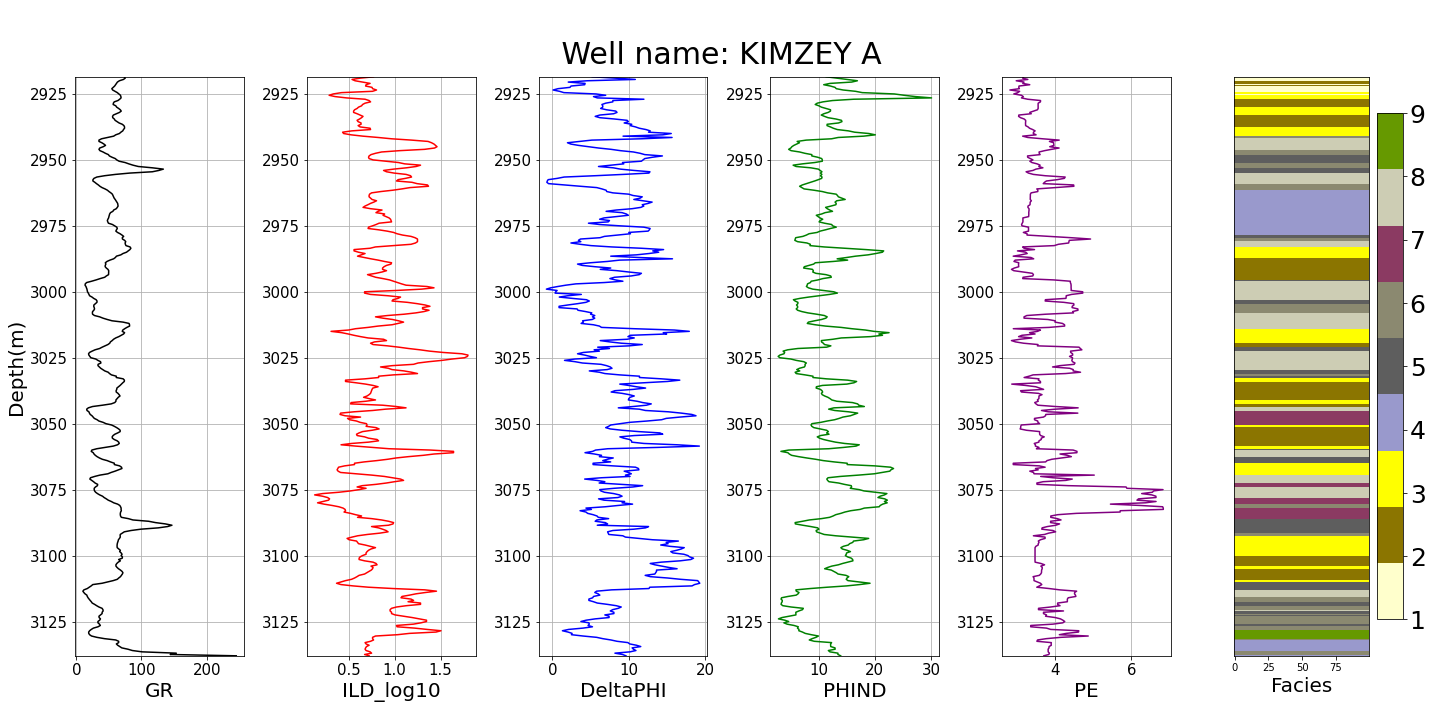

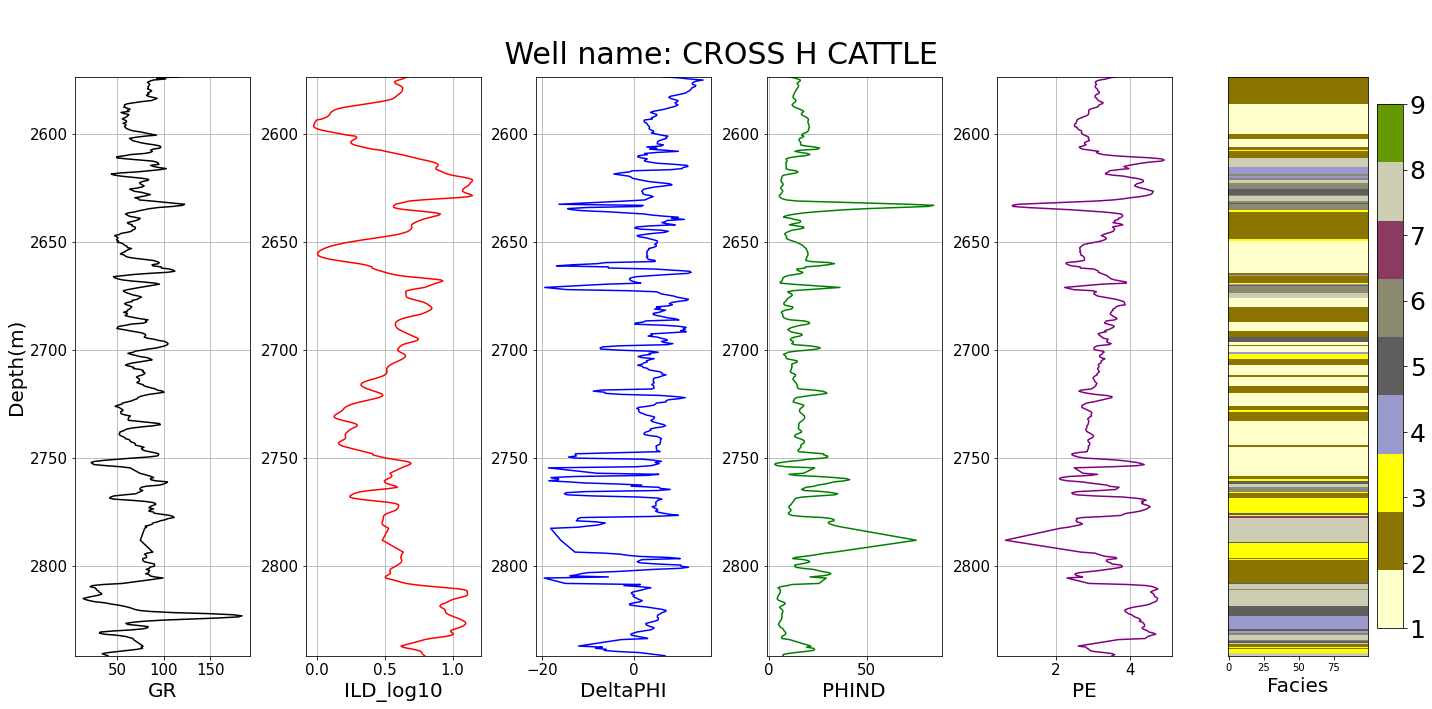

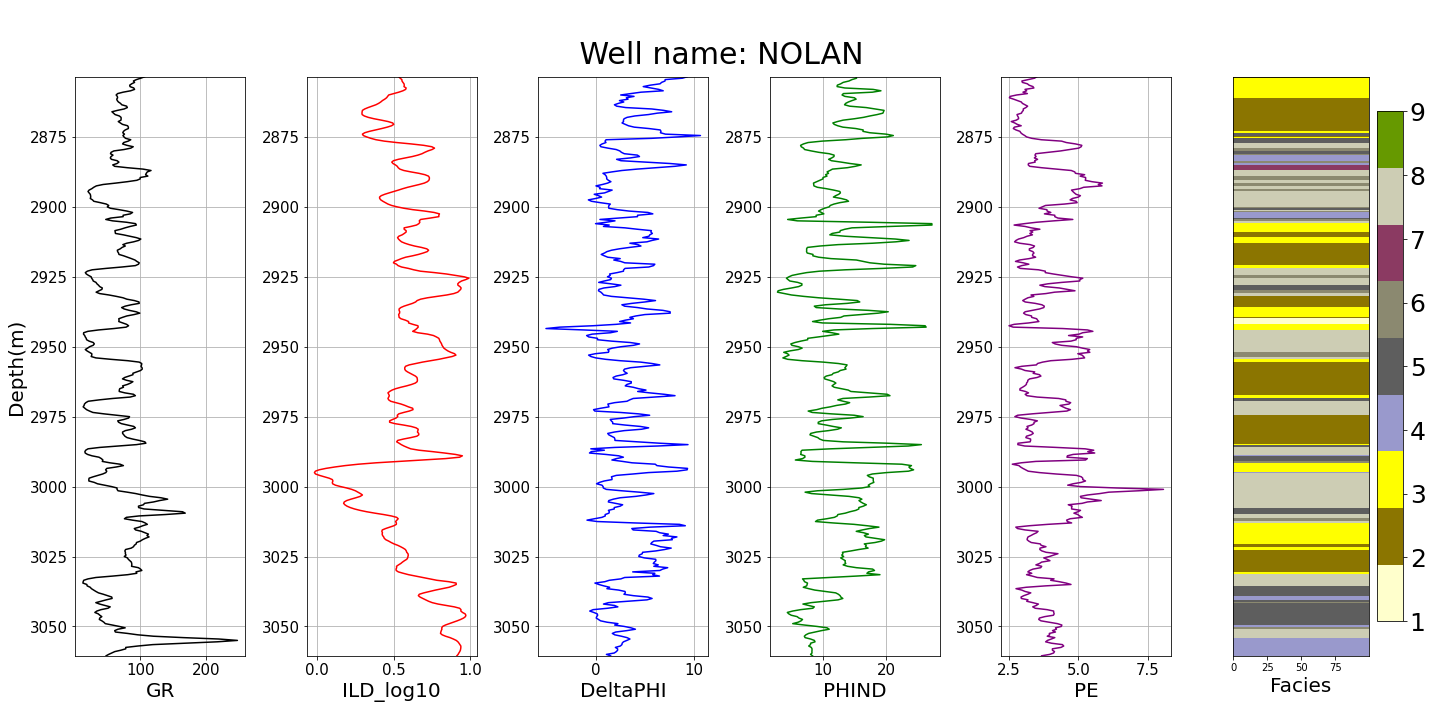

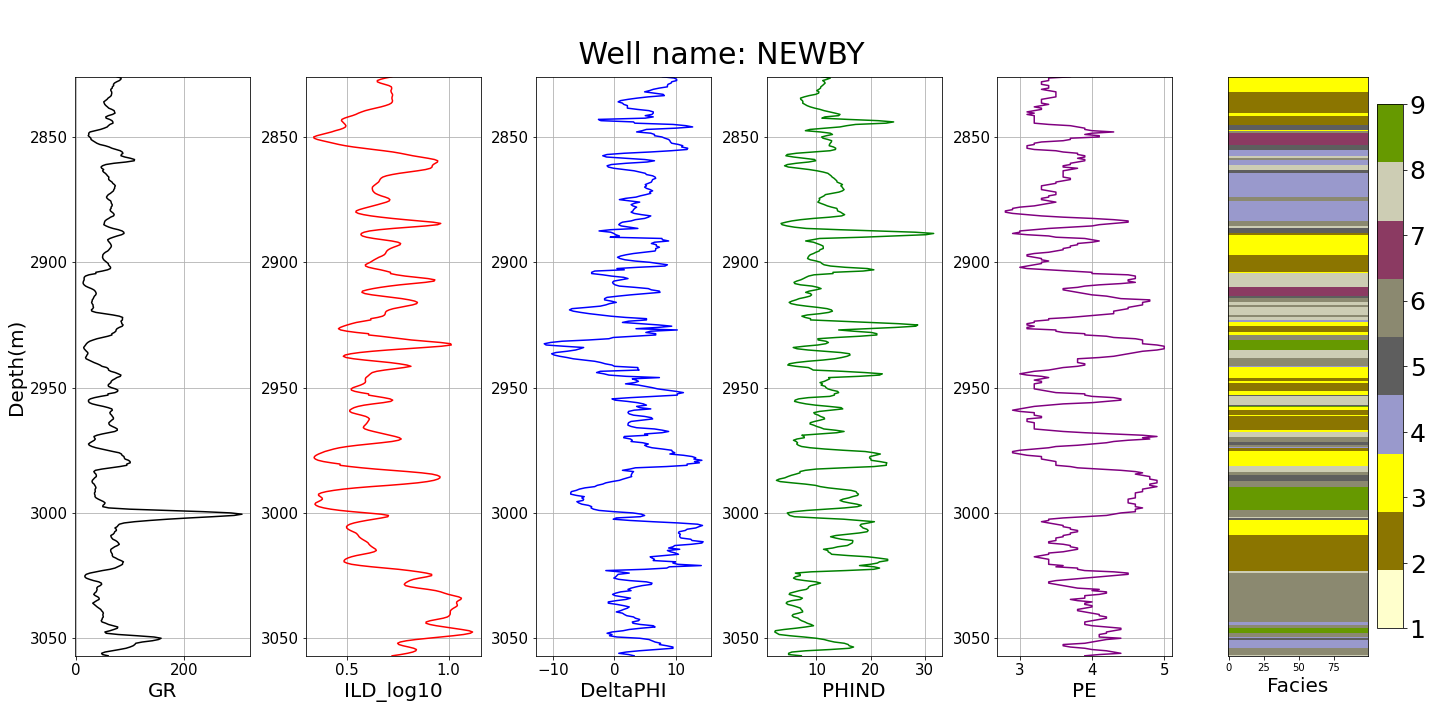

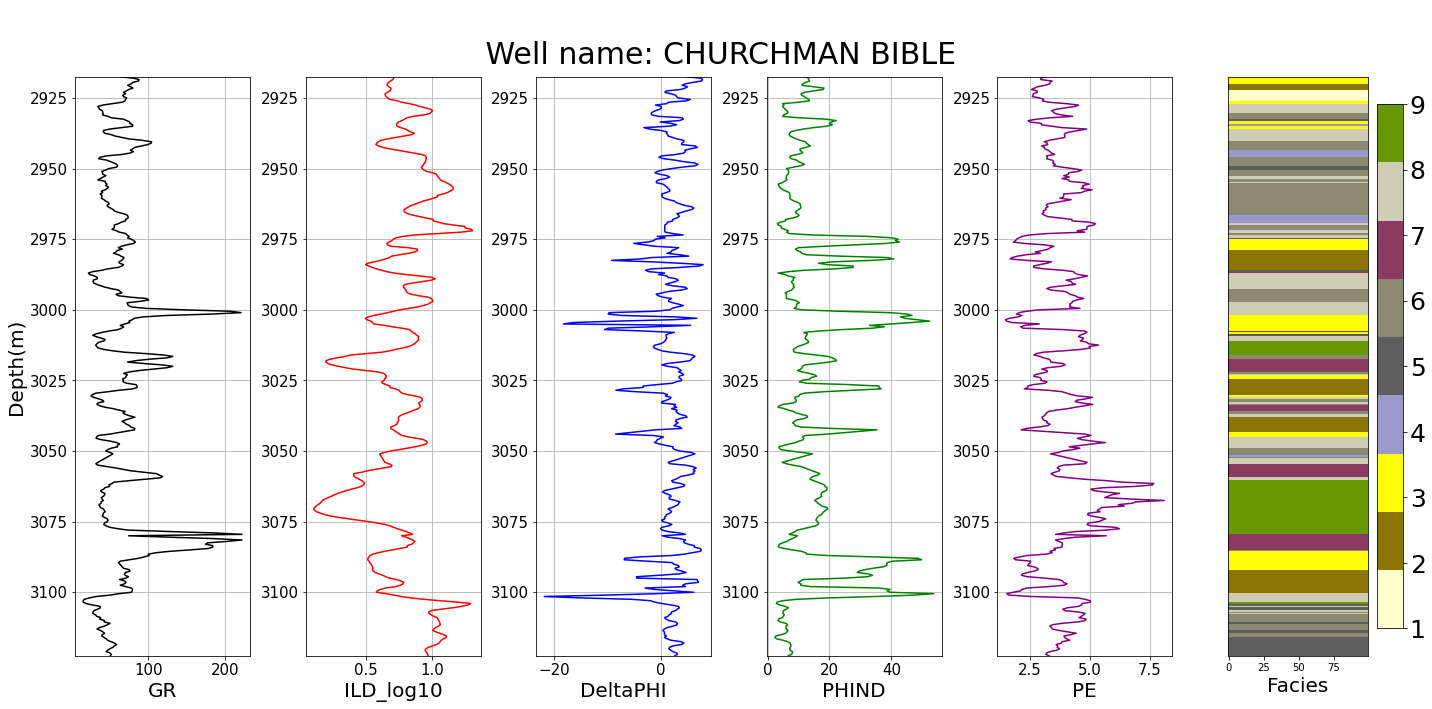

In [1515]:
# update the dataframe for these two wells with the imputed PE values and display the logs for each well
alexander_d = data_KNNimputed.loc[data['Well Name']=='ALEXANDER D']
kimzey_a = data_KNNimputed.loc[data['Well Name']=='KIMZEY A']

# display logs for each well
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,newby,churchman_bible]
for df in dflist:
    displayLogs(df, df['Well Name'].unique()[0], log_names, colormap)

## 3 Facies Prediction 

In this section we will try various supervised machine learnning models to predict Facies. 

Data preparation: we use well "Shrimplin" as the ultimate test dataset. For the other 8 wells, we split them into train and test(or actually validation) datasets. We select the best model and run prediction on the Shrimplin well.

<h2> 3.1 Test well selection </h2>

Since not all facies are present in all wells, when we choose the well to be left out as the ultimate test dataset, we should avoid to predit a facies value that does not present or with too little presence in the training dataset.

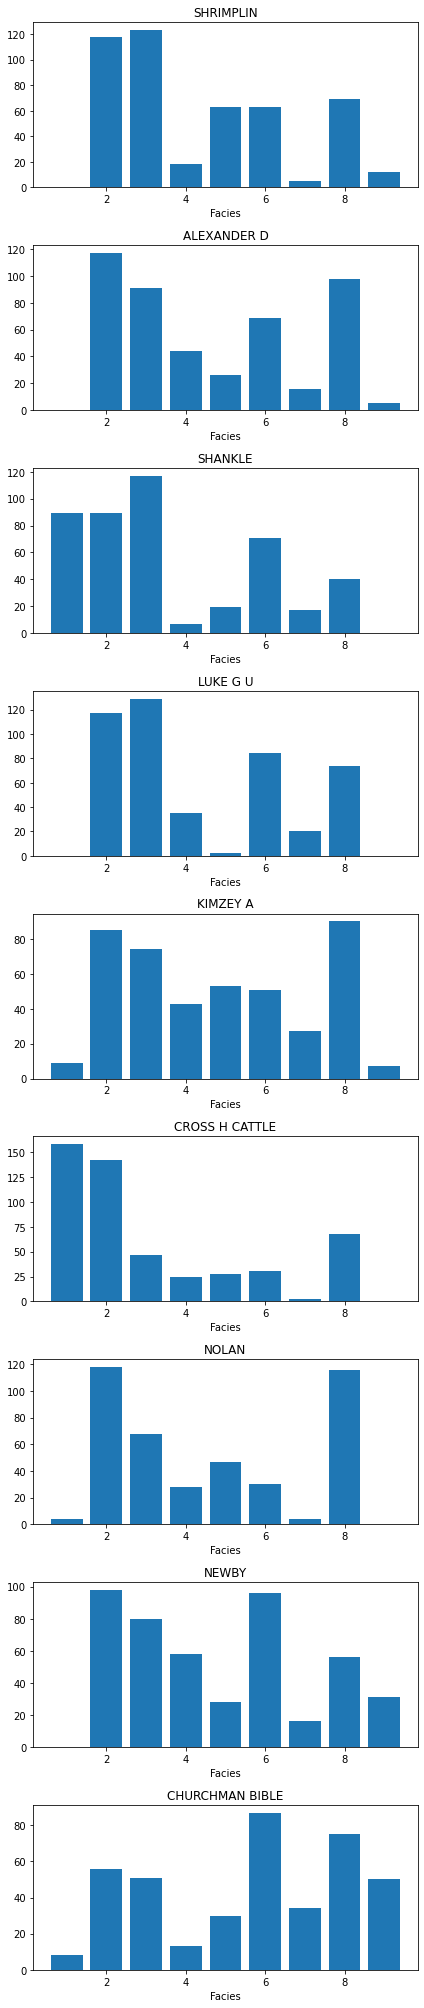

In [1516]:
# Plot facies distribution in each well 
fig, ax = plt.subplots(9,1, figsize=(6,28))
k=0
for k, w in enumerate(wellnames):
    a = data.loc[data['Well Name']==w].groupby("Facies").size()
    b=np.zeros(9)
    for i in np.arange(0,9):
        if i+1 in a:
            b[i]=a[i+1]
    ax[k].bar(np.arange(1,10),b)
    ax[k].set_title(w)
    ax[k].set_xlabel('Facies')
    k=k+1
plt.tight_layout()

After looking at facies distribution in each well, I choose to use well "Shrimplin" as the test data.

<h2> 3.2 Features selection </h2>

Text(0.5, 1.0, 'Heatmap of correlation between features')

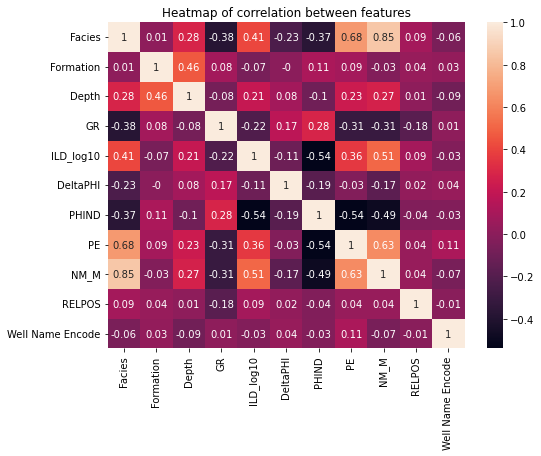

In [1564]:
data_num = data_KNNimputed.drop(['Well Name'], axis=1)
plt.subplots(figsize=(8,6))
sns.heatmap(np.round(data_num.corr(),2), annot=True)
plt.title('Heatmap of correlation between features')

Facies has weak correlation with formation and well name, therefore we will remove these two features from input data.

<h2> 3.3 We will try the following models:
    
    1. RandomForest
    2. KNN
    3. SVM 
</h2>

<h3>3.3.1 Prepare data for modeling </h3>

In [1518]:
from sklearn.preprocessing import MinMaxScaler

In [1519]:
testwell_df = data_KNNimputed.loc[data_KNNimputed['Well Name']=='SHRIMPLIN']
data_train = data_KNNimputed.loc[data_KNNimputed['Well Name']!='SHRIMPLIN']

X = data_train.drop(['Facies', 'Well Name', 'Well Name Encode', 'Formation'], axis=1)
y = data_train['Facies']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>3.3.2 Random Forest </h3>

In [1520]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


In [1521]:
def model_score(model, X, y, params, cv=5):
    model_cv = GridSearchCV(model, param_grid=params,cv=cv)
    model_cv.fit(X, y)
    print('Best accuracy is: ', model_cv.best_score_)
    print('Best parameters are: ', model_cv.best_params_)
    return model_cv

In [1522]:
# RandomForest model
rf = RandomForestClassifier(random_state=42)
n_estimators = np.int64(np.linspace(100, 200, 3))
max_depth = [4,5,6,7]
params = {"n_estimators": n_estimators,
         "max_depth": max_depth}
best_rf_model = model_score(rf, X_train_scaled, y_train, params, 3)

Best accuracy is:  0.6532260166840458
Best parameters are:  {'max_depth': 7, 'n_estimators': 150}


In [1523]:
# apply the best model parameters to the entire training set
rf_best = RandomForestClassifier(max_depth = best_rf_model.best_params_['max_depth'], 
                                 n_estimators = best_rf_model.best_params_['n_estimators'], 
                                 random_state = 42)
rf_best.fit(X_train_scaled, y_train)
y_pred_rf = rf_best.predict(X_test_scaled)
# print the score
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.96      0.60      0.74        43
           2       0.63      0.87      0.73       155
           3       0.77      0.55      0.64       139
           4       0.61      0.81      0.70        48
           5       0.50      0.07      0.12        44
           6       0.64      0.71      0.67       124
           7       0.90      0.64      0.75        28
           8       0.63      0.78      0.70       113
           9       1.00      0.46      0.63        26

    accuracy                           0.68       720
   macro avg       0.74      0.61      0.63       720
weighted avg       0.69      0.68      0.66       720



Text(0.5, 1.0, 'Confusion Matrix, Random Forest')

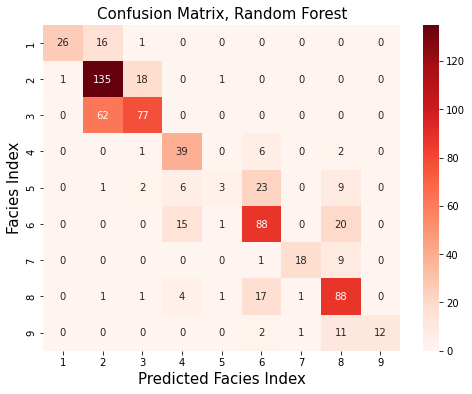

In [1524]:
facies_values = np.sort(data.Facies.unique())

# plot confusion metrix
plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.0f', cmap='Reds',
            xticklabels=facies_values, yticklabels=facies_values)
plt.ylabel('Facies Index', fontsize=15)
plt.xlabel('Predicted Facies Index', fontsize=15)
plt.title('Confusion Matrix, Random Forest', fontsize=15)

<h3>3.3.3 K Nearest Neighbours </h3>

In [1525]:
# KNN model
knn = KNeighborsClassifier()
n_neighbors = np.int64(np.linspace(4, 10, 7))
p = [1, 2]
params = {"n_neighbors": n_neighbors, 
          "p": p}
best_knn_model = model_score(knn, X_train_scaled, y_train, params, 3)

Best accuracy is:  0.7105604072529256
Best parameters are:  {'n_neighbors': 4, 'p': 1}


In [1526]:
knn_best = KNeighborsClassifier(n_neighbors=best_knn_model.best_params_['n_neighbors'], p=best_knn_model.best_params_['p'])
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.75      0.88      0.81        43
           2       0.72      0.86      0.78       155
           3       0.82      0.63      0.72       139
           4       0.68      0.96      0.79        48
           5       0.54      0.45      0.49        44
           6       0.72      0.70      0.71       124
           7       0.74      0.71      0.73        28
           8       0.79      0.73      0.76       113
           9       0.95      0.69      0.80        26

    accuracy                           0.74       720
   macro avg       0.74      0.74      0.73       720
weighted avg       0.75      0.74      0.74       720



Text(0.5, 1.0, 'Confusion Matrix, KNN')

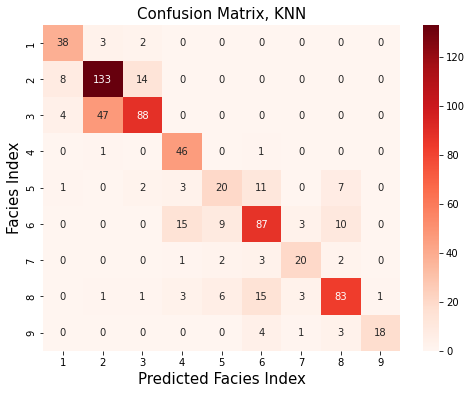

In [1527]:
# plot confusion metrix
plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='.0f', cmap='Reds',
            xticklabels=facies_values, yticklabels=facies_values)
plt.ylabel('Facies Index', fontsize=15)
plt.xlabel('Predicted Facies Index', fontsize=15)
plt.title('Confusion Matrix, KNN', fontsize=15)

<h3>3.3.4 SVM </h3>

In [1528]:
from sklearn.svm import SVC

In [1529]:
svc = SVC(kernel='rbf', gamma=1)
C = [0.001, 0.01, 0.1, 1, 10]
degree=[1,2,3]
params = {"C": C,
         "degree": degree}
best_svc_model = model_score(svc, X_train_scaled, y_train, params, 3)

svc_best = SVC(degree=best_svc_model.best_params_['degree'], C=best_svc_model.best_params_['C'])
svc_best.fit(X_train_scaled, y_train)
y_pred_svc = svc_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svc))

Best accuracy is:  0.6365524707449889
Best parameters are:  {'C': 10, 'degree': 1}
              precision    recall  f1-score   support

           1       0.80      0.56      0.66        43
           2       0.64      0.83      0.72       155
           3       0.78      0.63      0.69       139
           4       0.63      0.77      0.69        48
           5       0.47      0.16      0.24        44
           6       0.61      0.61      0.61       124
           7       0.84      0.75      0.79        28
           8       0.64      0.77      0.70       113
           9       0.90      0.69      0.78        26

    accuracy                           0.67       720
   macro avg       0.70      0.64      0.65       720
weighted avg       0.68      0.67      0.66       720



Text(0.5, 1.0, 'Confusion Matrix, SVM')

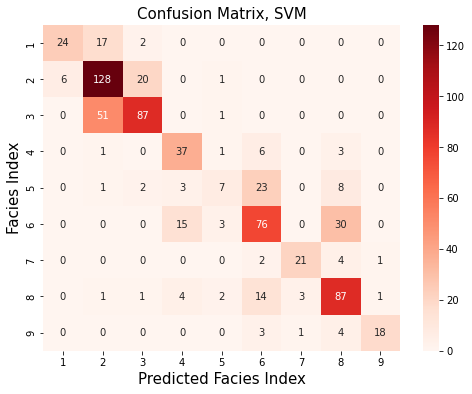

In [1530]:
# plot confusion metrix
plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, fmt='.0f', cmap='Reds',
            xticklabels=facies_values, yticklabels=facies_values)
plt.ylabel('Facies Index', fontsize=15)
plt.xlabel('Predicted Facies Index', fontsize=15)
plt.title('Confusion Matrix, SVM', fontsize=15)

<h3> Summary of modeling results (Cross-validation accuracy, training set accuracy): </h3>

    - Random Forest: 0.65, 0.68
    - KNN: 0.71, 0.74
    - SVM: CV accuracy 0.64, 0.67
    

<h3>3.3.5 Re-evaluate accuracy allowing mis-classification with neighboring facies</h3>

Deposition is a very slow and continuous process, and there is transition between different facies, therefore facies classification is not always a clearcut. For example it is possible to mis-classify facies 2 with 1 or 3.

In [1531]:
from sklearn.metrics import accuracy_score

In [1532]:
def cal_accuracy(a, b, tol=tolmap):
    total = len(a)
    count=0
    for k, (a,b) in enumerate(zip(a,b)):
        if (b==a or b in tolmap[a]):
            count+=1
    return np.round(count/total,3)

In [1533]:
tolmap={1:[2],
        2:[1,3],
        3:[2,4],
        4:[3,5],
        5:[4,6],
        6:[5,7,8],
        7:[6,8],
        8:[7,9],
        9:[8]}

rf_accuracy_tol = cal_accuracy(y_test, y_pred_rf)
print("Random Forest accuracy (exact classification):", np.round(accuracy_score(y_test, y_pred_rf),3))
print("Random Forest accuracy (mis-classification with neighboring facies):", rf_accuracy_tol)

knn_accuracy_tol = cal_accuracy(y_test, y_pred_knn)
print("KNN accuracy (exact classification):", np.round(accuracy_score(y_test, y_pred_knn),3))
print("KNN accuracy (mis-classification with neighboring facies):", knn_accuracy_tol)


svc_accuracy_tol = cal_accuracy(y_test, y_pred_svc)
print("SVM accuracy (exact classification):", np.round(accuracy_score(y_test, y_pred_svc),3))
print("SVM accuracy (mis-classification with neighboring facies):", svc_accuracy_tol)


Random Forest accuracy (exact classification): 0.675
Random Forest accuracy (mis-classification with neighboring facies): 0.911
KNN accuracy (exact classification): 0.74
KNN accuracy (mis-classification with neighboring facies): 0.907
SVM accuracy (exact classification): 0.674
SVM accuracy (mis-classification with neighboring facies): 0.907


<h4>Based on the performance of different models, I'd choose KNN as the final model and apply it to the test well. </h4>

<h2>3.4 Predict On Test Well </h2>

<h3>3.4.1 Exact classification </h3>

In [1534]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [1535]:
def displayFacies(df, real, predicted, method, cmap):
    fig, axes = plt.subplots(1, 2, figsize=(6,6), sharey=True)

    for key in facies_cmap.keys():
        axes[0].fill_betweenx(df['Depth'], 0, 1, 
                              where=(df['Facies']==key),
                              facecolor=facies_cmap[key])
        axes[0].set_xlabel(real, fontsize=20)
    
    for key in facies_cmap.keys():
        axes[1].fill_betweenx(df['Depth'], 0, 1, 
                          where=(df['Predicted Facies']==key),
                          facecolor=facies_cmap[key])
        axes[1].set_xlabel(predicted, fontsize=20)
            
    axes[0].invert_yaxis()
    axes[0].set_ylabel('Depth(m)', fontsize=20)
    fig.suptitle('SHRIMPLIN, '+ method, fontsize=22)

In [1536]:
X_testwell = scaler.transform(testwell_df.drop(['Facies', 'Well Name', 'Well Name Encode', 'Formation'], axis=1))
y_testwell = testwell_df['Facies']
testwell_Facies = testwell_df[['Depth', 'Facies']]

In [1537]:
# predict on SHRIMPLIN
y_testwell_pred_knn = knn_best.predict(X_testwell)
print(classification_report(y_testwell, y_testwell_pred_knn))
testwell_Facies['Predicted Facies'] = y_testwell_pred_knn.tolist()
#displayFacies(testwell_Facies, 'Facies', 'Predicted Facies', 'KNN', colormap)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.59      0.64      0.62       118
           3       0.71      0.56      0.63       123
           4       0.59      0.56      0.57        18
           5       0.35      0.22      0.27        63
           6       0.52      0.70      0.60        63
           7       0.00      0.00      0.00         5
           8       0.52      0.64      0.58        69
           9       0.50      0.17      0.25        12

    accuracy                           0.55       471
   macro avg       0.42      0.39      0.39       471
weighted avg       0.56      0.55      0.55       471



C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hyuan\anaconda3\envs\myenv_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hyuan\AppData\Local\Temp\ipyker

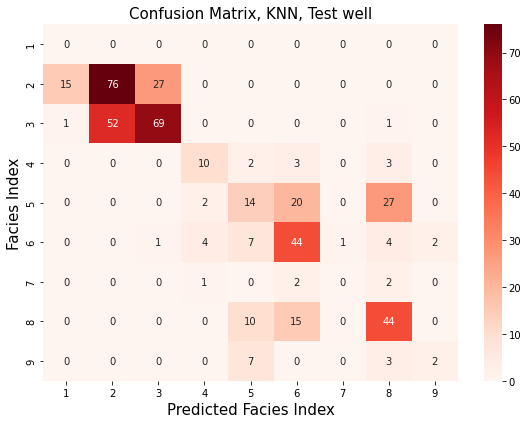

In [1565]:
# plot confusion metrix
plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_testwell, y_testwell_pred_knn), annot=True, fmt='.0f', cmap='Reds',
            xticklabels=facies_values, yticklabels=facies_values)
plt.ylabel('Facies Index', fontsize=15)
plt.xlabel('Predicted Facies Index', fontsize=15)
plt.title('Confusion Matrix, KNN, Test well', fontsize=15)
plt.tight_layout()

<h3> 3.4.2 Re-evaluate accuracy allowing mis-classification with neighboring facies </h3>

In [1539]:
knn_accuracy_testwell_tol = cal_accuracy(y_testwell, y_testwell_pred_knn)
print("KNN modeling accuracy for test well SHIMPLIN:") 
print("  Exact classification:", np.round(accuracy_score(y_testwell, y_testwell_pred_knn),3))
print("  Allowing mis-classification with neighboring facies):", knn_accuracy_testwell_tol)

KNN modeling accuracy for test well SHIMPLIN:
  Exact classification: 0.55
  Allowing mis-classification with neighboring facies): 0.841
